In [ ]:
# Access google drive
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

# Importing the necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import math
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import statsmodels.api as sm

# Data Preparation
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn import datasets

# ML Algorithms to be used
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as LGBMClassifier

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import FastICA

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



'2.4.1'

#1. Analysis of the Problem

source of data: https://www.kaggle.com/malekzadeh/motionsense-dataset



##Understanding the Problem
The collected data comes from motion sensors of a mobile phone (accelerometer and gyroscope). 24 Subjects were asked to walk 15 trials. During that, they had to perform 6 different activities.
I had several reasons **why I chose that Dataset**:
  
*   I am interested in the sensor Data (how does raw data from an accelerometer and gyroscope look like, how do you have to process them)

*   I am interested in the principle of how an accelometer and a gyroscope work

*   I think it's pretty useful, if you can predict a persons activity like on a smart watch when doing sport.

**my goals** are to have a model that is

*    able to predict whether a person is sitting, standing, walking, jogging, going upstairs or going downstairs.

*   also maybe (when i got time) able to predict gender, weight, height and age (--> multilabel - though I think that I might not have enough data to train the model for a high enough accuracy)

The **type of Problem** I think I am dealing with is a **multi-classification** problem. I have labeld data, so I am able to have supervised learning. I want to have a descrete Output (e.g. walking yes/no) and have more than two classes. 


#2. Data Exploration and Preparation

## Understanding the data

All the data is in a file called 'A_DeviceMotion_data'. Inside that file there are 15 further files (15 trials). Here is a picture thats shows us the sequence of the trials.

![picture](https://drive.google.com/uc?export=view&id=1tEV8gCwwW4M68f8tDzLrX9TVA8CKQvGn)






24 participants walked 15 trials. During that, they performed 6 activities

1. dws: downstairs (1, 3, 11)

2. ups: upstairs (3, 4, 12)

3. sit: sitting (5, 13)

4. std: standing (6, 14)

5. wlk: walking (7, 8, 15)

6. jog: jogging (9, 16)



Trials 1-9:  2 - 3 minutes

Trials 10-16:  0.5 - 1 minutes

For every trial we have a multivariate time-series. Thus, we have time-series with 12 features: attitude.roll, attitude.pitch, attitude.yaw, gravity.x, gravity.y, gravity.z, rotationRate.x, rotationRate.y, rotationRate.z, userAcceleration.x, userAcceleration.y, userAcceleration.z.

The accelerometer measures the sum of two acceleration vectors: gravity and user acceleration. User acceleration is the acceleration that the user imparts to the device. Using both the gyroscope and the accelerometer, we can differentiate between gravity and user acceleration. 

\\
12 features per time series
*   attitude.roll (rollen) (Gyroskop)
*   attitude.pitch (nicken) (Gyroskop)
*   attitude.yaw (gier) (Gyroskop)
*   gravity.x (Gyroskop + Accelerometer)
*   gravity.y (Gyroskop + Accelerometer)
*   gravity.z (Gyroskop + Accelerometer)
*   rotationRate.x (Gyroskop)
*   rotationRate.y (Gyroskop)
*   rotationRate.z (Gyroskop)
*   userAcceleration.x (Gyroskop + Accelerometer)
*   userAcceleration.y (Gyroskop + Accelerometer)
*   userAcceleration.z (Gyroskop + Accelerometer)




## Building the Dataset


In [ ]:
#######################################################
##### Building the dataset as described on GitHub #####
#######################################################
def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
os.chdir('/content/drive/MyDrive/Uni/Uni Master/Master Semester 3/Data Driven Engineering I/dataset/')
sdt = ["attitude", "userAcceleration", 'gravity', 'rotationRate']
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS [0:6]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
# replacing activity numbers with their abbrevation
act_dict = {0: 'dws',
            1: 'ups',
            2: 'wlk',
            3: 'jog',
            4: 'std',
            5: 'sit'}
                
dataset['label'] =  dataset.act.apply(lambda act: act_dict[act])

dataset.info()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration', 'gravity', 'rotationRate']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412865 entries, 0 to 1412864
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   attitude.roll       1412865 non-null  float64
 1   attitude.pitch      1412865 non-null  float64
 2   attitude.yaw        1412865 non-null  float64
 3   userAcceleration.x  1412865 non-null  float64
 4   userAcceleration.y  1412865 non-null  float64
 5   userAcceleration.z  1412865 non-null  float64
 6   gravity.x           1412865 non-null  float64
 7   gravity.y           1412865 non-null  float64
 8   gravity.z           1412865 non-null  float64
 9   rotationRate.x  

## Choosing the Metric

We'll have a look in the distribution of the 6 classes

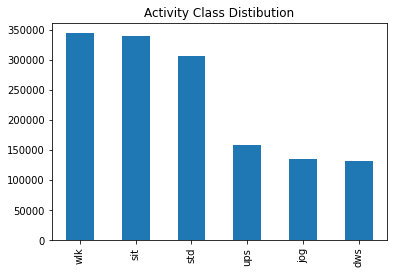

In [ ]:
activity_counts = dataset.label.value_counts()
activity_counts.plot(kind='bar', title='Activity Class Distibution')
plt.show()

As there are some underrepresented classes I will use Precision Recall curves as a metric. I will also use log loss. Therefore I will calculate the 'dumb log loss' later on.

## NaN's and Uniqueness

In [ ]:
# Check if there are NaN's
nanCounter = dataset.isna().sum()
print(nanCounter,'\n')

# Check uniqueness
distinctCounter = dataset.apply(lambda x: len(x.unique()))
print(distinctCounter)

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
act                   0
id                    0
weight                0
height                0
age                   0
gender                0
trial                 0
label                 0
dtype: int64 

attitude.roll         1195863
attitude.pitch         788251
attitude.yaw          1192491
userAcceleration.x     612164
userAcceleration.y     680018
userAcceleration.z     654542
gravity.x              809558
gravity.y              489563
gravity.z              829808
rotationRate.x         849745
rotationRate.y         878845
rotationRate.z         773557
act                         6
id                         24
weight                     17
height                     15
age                      

No NaN's and nothing unusual in the Dataset. As aspected 6 different activities, 15 different trials and 24 different id's for the different participants. Raw Sensor data also looks good.

## Statistical Tools

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dataset.describe()

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial
count,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000
mean,-0.176,-0.987,-0.149,-0.004,0.044,0.039,0.042,0.755,-0.139,0.005,0.015,0.013,2.950,11.472,72.121,173.989,28.832,0.574,7.573
std,1.567,0.494,1.545,0.328,0.528,0.376,0.339,0.333,0.428,1.293,1.226,0.808,1.644,6.925,15.981,8.799,5.303,0.495,3.901
min,-3.142,-1.570,-3.142,-6.369,-5.674,-7.743,-1.000,-1.000,-1.000,-17.366,-18.414,-12.151,0.000,0.000,48.000,161.000,18.000,0.000,1.000
25%,-1.480,-1.358,-1.278,-0.048,-0.062,-0.024,-0.173,0.584,-0.392,-0.286,-0.167,-0.097,2.000,6.000,60.000,164.000,25.000,0.000,5.000
50%,0.122,-1.181,-0.136,0.001,0.004,0.003,0.020,0.925,-0.097,-0.000,0.000,0.000,3.000,12.000,72.000,175.000,28.000,1.000,7.000
75%,0.876,-0.623,0.829,0.044,0.052,0.105,0.272,0.978,0.085,0.116,0.231,0.113,4.000,18.000,78.000,180.000,31.000,1.000,9.000
max,3.142,1.567,3.142,7.121,7.323,8.125,1.000,1.000,0.981,10.468,17.543,11.436,5.000,23.000,102.000,190.000,46.000,1.000,16.000


## Correlation Matrix

In [ ]:
correlationMatrix = pd.DataFrame(dataset).corr() 
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial
attitude.roll,1.00,-0.01,0.02,-0.08,0.01,0.07,0.68,0.01,-0.37,-0.02,0.02,0.00,-0.10,-0.13,0.04,0.03,0.10,-0.04,-0.01
attitude.pitch,-0.01,1.00,0.04,-0.02,-0.04,-0.01,0.14,-0.98,-0.24,-0.00,-0.03,0.00,0.44,-0.02,0.03,0.06,0.05,0.04,0.05
attitude.yaw,0.02,0.04,1.00,0.01,0.01,-0.02,-0.02,-0.03,-0.01,-0.00,0.01,0.00,-0.08,0.02,0.06,-0.03,-0.01,-0.05,-0.05
userAcceleration.x,-0.08,-0.02,0.01,1.00,-0.03,-0.20,-0.10,0.01,0.08,-0.03,-0.04,0.05,0.01,-0.03,0.00,0.01,0.03,0.02,-0.00
userAcceleration.y,0.01,-0.04,0.01,-0.03,1.00,-0.09,0.01,0.04,0.01,0.08,0.02,-0.01,-0.05,0.01,0.02,0.03,0.00,0.03,0.02
userAcceleration.z,0.07,-0.01,-0.02,-0.20,-0.09,1.00,0.04,0.03,-0.17,0.01,-0.01,-0.02,-0.05,0.01,0.00,-0.00,-0.02,0.01,0.04
gravity.x,0.68,0.14,-0.02,-0.10,0.01,0.04,1.00,-0.12,-0.48,-0.02,0.01,0.00,0.06,-0.19,0.13,0.07,0.10,-0.04,0.02
gravity.y,0.01,-0.98,-0.03,0.01,0.04,0.03,-0.12,1.00,0.23,0.00,0.02,0.00,-0.47,0.01,-0.03,-0.07,-0.03,-0.03,-0.05
gravity.z,-0.37,-0.24,-0.01,0.08,0.01,-0.17,-0.48,0.23,1.00,-0.01,0.02,-0.05,-0.10,0.03,-0.06,-0.06,-0.10,-0.09,-0.03
rotationRate.x,-0.02,-0.00,-0.00,-0.03,0.08,0.01,-0.02,0.00,-0.01,1.00,-0.16,0.40,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00


## Feature Engineering

We should have a look on the Time Series to see which usefull features could be derived of them. Therefor, we will look at random chosen frames.

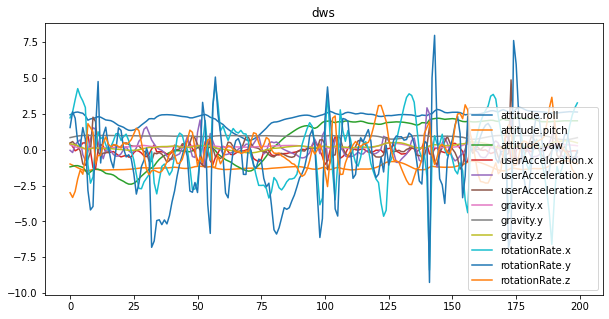

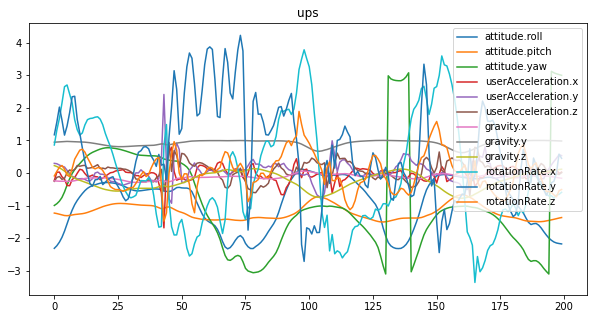

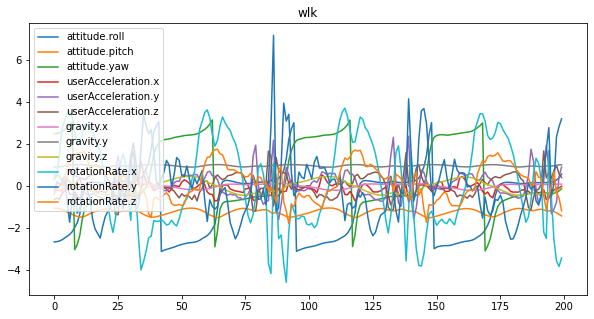

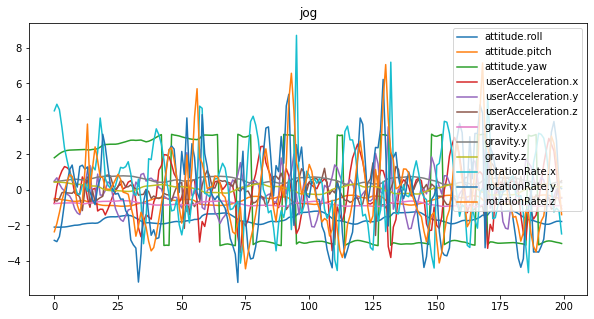

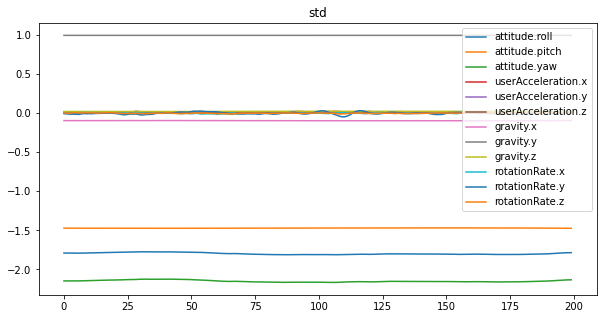

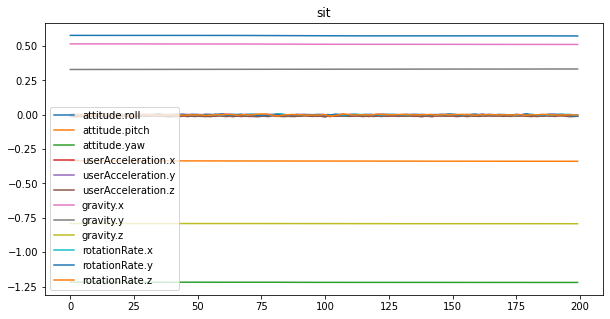

In [ ]:
metrics = ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x', 'userAcceleration.y', 
            'userAcceleration.z', 'gravity.x', 'gravity.y' ,'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z']

start_position = np.random.randint(1,130000)
end_position = start_position + 200

for label in dataset.label.unique():
    random_dataFrame = dataset[dataset['label']==label].iloc[start_position:end_position].reset_index()
    for metric in metrics:
      random_dataFrame[metric].plot(title=label, legend=True, figsize=(10, 5))
    plt.show()

following features will be calculated for each metric
* mean
* min
* max
* std

After engineering those we will have a look of how they are distributed to be able to see wether you can distinguish some activities by these features or not.


## Noice reduction

The Acceleration data is noisy, so I first reduced the noise, but it made the predictions worse unfortunatley. On the picture you can see that especially 'jog' (jogging) lost some precission. Reducing the noise made it less distinguishable.

![picture](https://drive.google.com/uc?export=view&id=1r6eh_3W_yB_OkrZzkxIRv4CQ9tNFcNUI)

In [ ]:
# # before noise reduction
# print('before denoising')
# dataset['userAcceleration.x'].iloc[0:800].plot()
# plt.show()

# direction = ('x','y','z')
# for i in direction:
#   dataset[f'userAcceleration.{i}'] = dataset[f'userAcceleration.{i}'].rolling(20).median()

# # after noise reduction
# print('after denoising')
# dataset['userAcceleration.x'].iloc[0:800].plot()
# plt.show()

In [ ]:
# new_metric_ups = dataset.loc[dataset['label']=='ups', 'userAcceleration.z'].abs()*dataset.loc[dataset['label']=='ups', 'attitude.pitch'].abs()
# print('ups: ', new_metric_ups.describe())

# new_metric_dws = dataset.loc[dataset['label']=='dws', 'userAcceleration.z'].abs()*dataset.loc[dataset['label']=='dws', 'attitude.pitch'].abs()
# print('dws: ', new_metric_dws.describe())

# dataset['accZ_TIMES_pitch'] = new_metric_dws = dataset['userAcceleration.z'].abs()*dataset['attitude.pitch'].abs()


In [ ]:
metrics = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 
           'attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 
           'gravity.y' ,'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z']

def build_features(data, number_of_frames=200, metrics=metrics):
    instances = pd.DataFrame()
    instance = 0
    for label in data.label.unique():
        print(f"Building features for {label}...")
        start_position=0
        label_df = data[data['label']==label]
        while len(label_df) > start_position+number_of_frames:
            for metric in metrics:
                instance_df = label_df.iloc[start_position:start_position+number_of_frames].reset_index()
                instances.loc[instance, 'label'] = label
                instances.loc[instance, f'median_{metric}'] = instance_df[metric].median()
                instances.loc[instance, f'std_{metric}'] = instance_df[metric].std()
                instances.loc[instance, f'min_{metric}'] = instance_df[metric].min()
                instances.loc[instance, f'max_{metric}'] = instance_df[metric].max()
                # fourier = np.fft.rfft(instance_df[metric])[1:]
                # amplitude = max(np.abs(fourier))
                # frequency = np.where(np.abs(fourier)==amplitude)[0][0]
                # instances.loc[instance, f'amplitude_{metric}'] = amplitude
                # instances.loc[instance, f'frequency_{metric}'] = frequency
            instance = instance + 1
            start_position = start_position + number_of_frames
    return instances

instances = build_features(data=dataset)

Building features for dws...
Building features for ups...
Building features for wlk...
Building features for jog...
Building features for std...
Building features for sit...


Lets see how many Data is left for Training and Testing...

In [ ]:
instances.label.value_counts()

wlk    1721
sit    1693
std    1532
ups     786
jog     671
dws     659
Name: label, dtype: int64

## Feature Distributions

lets see how the builded features are distributed

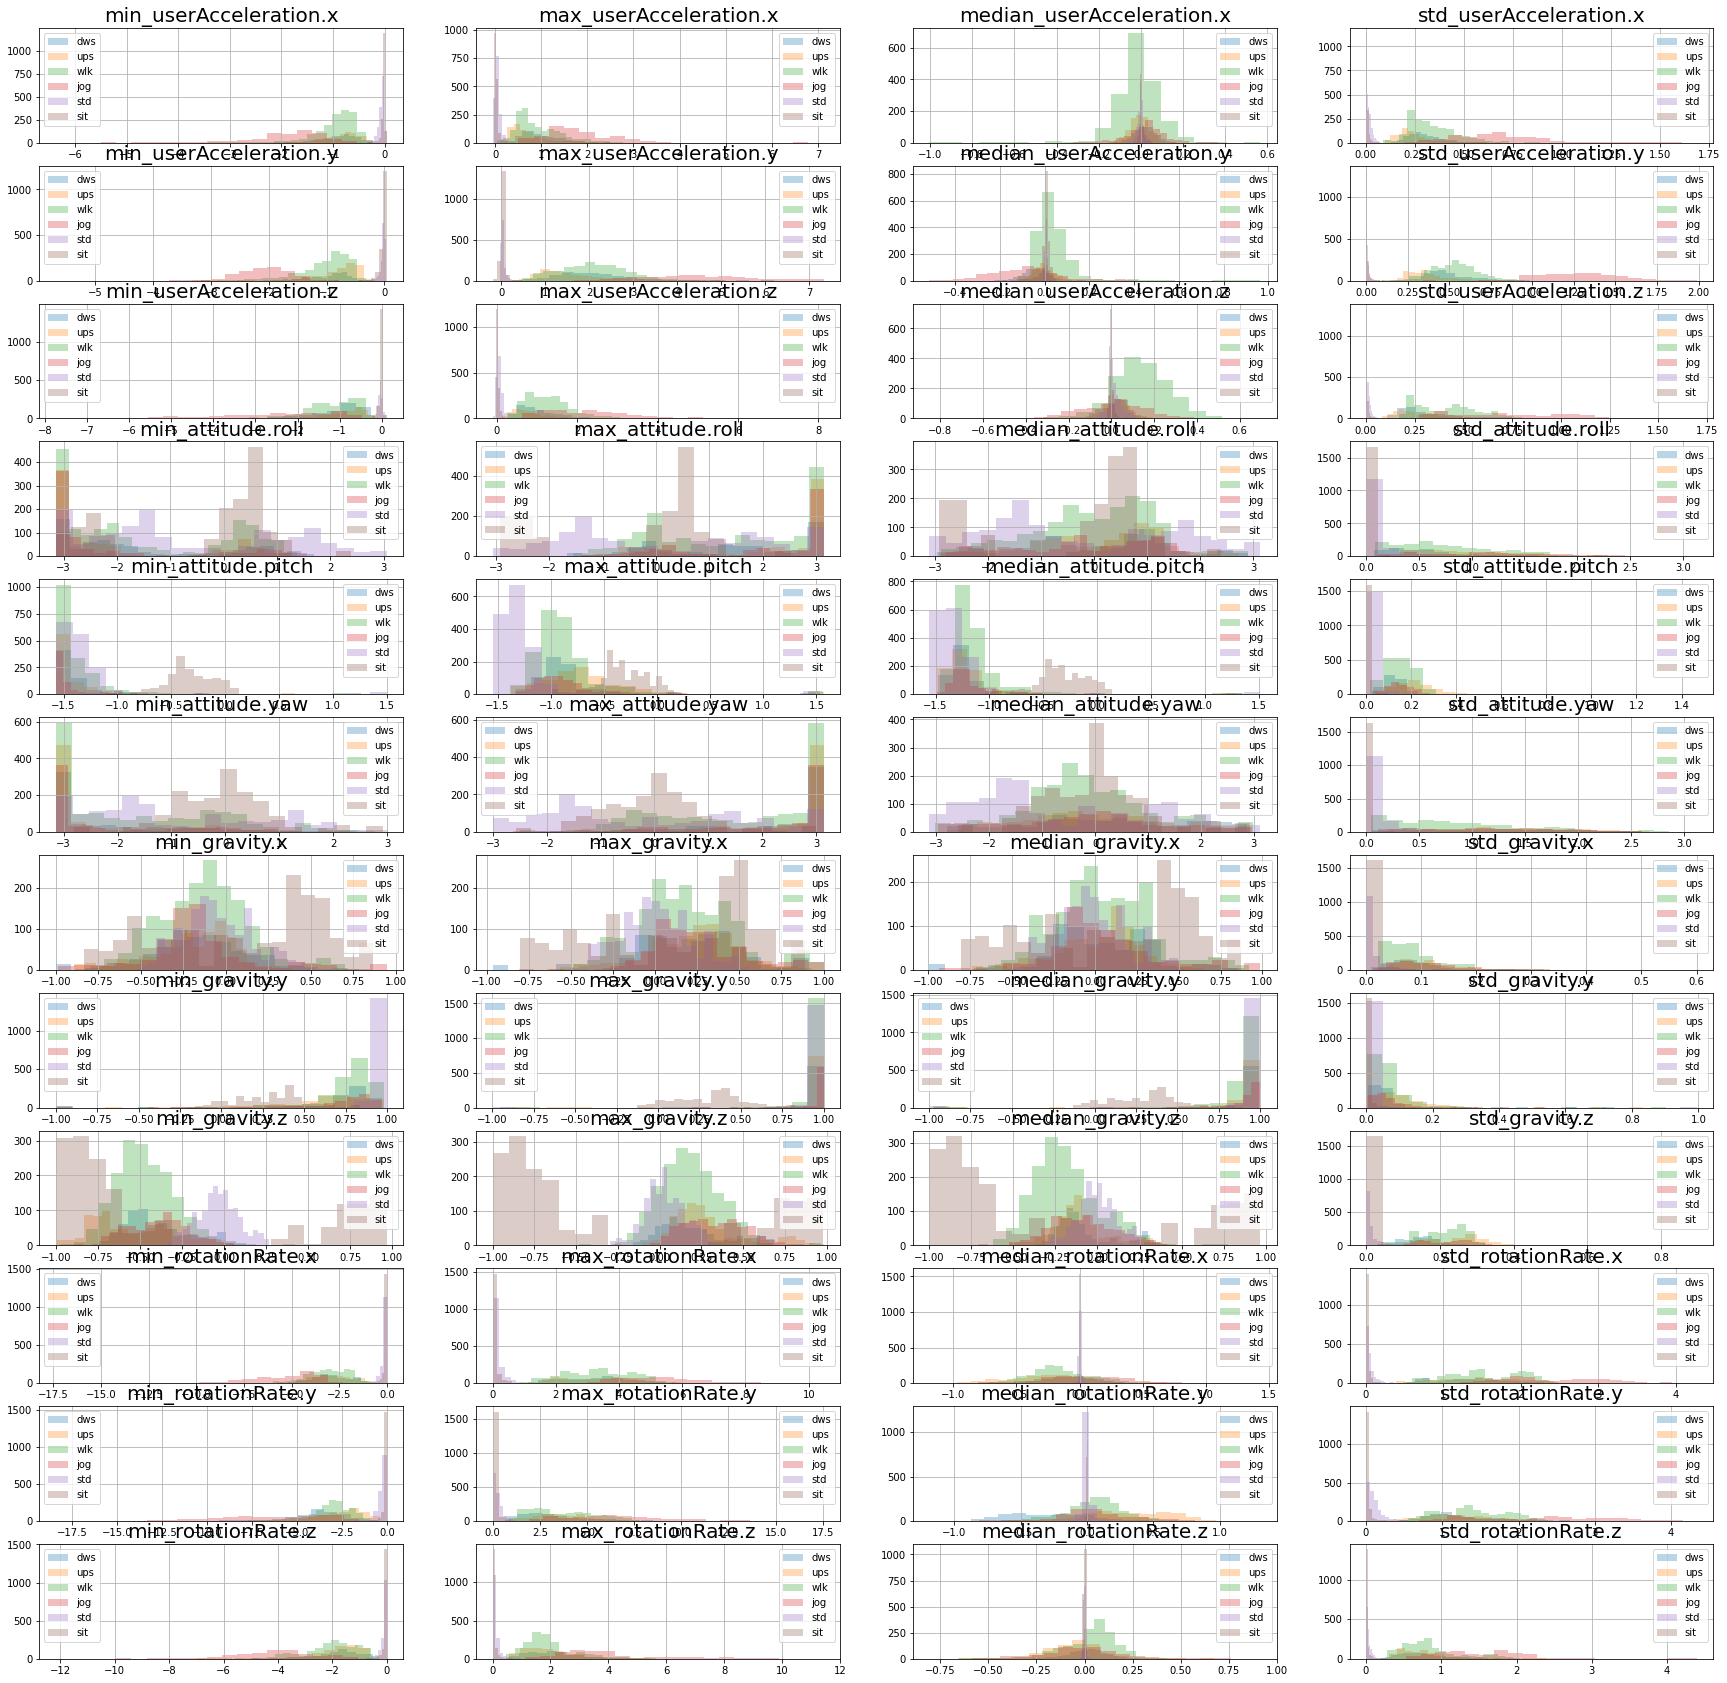

In [ ]:
features = ['min', 'max', 'median', 'std'] #, 'frequency', 'amplitude'
fig, ax = plt.subplots(len(metrics), len(features))
fig.set_size_inches(30,30)
for m_index, metric in enumerate(metrics):
  for f_index, feature in enumerate(features):
    plt.axes(ax[m_index, f_index])
    ax[m_index, f_index].set_title(f'{feature}_{metric}', fontsize=20)
    for label in instances.label.unique():
      for curr in [f'{feature}_{metric}']:
          instances[instances.label==label][curr].hist(alpha=0.3, label=label, bins=20)
    plt.legend()
    #ax[f_index, m_index].xaxis.set_visible(False)
plt.show()

Conclusions:
* jogging (jog) can be told apart from all other activities  by **std_userAccelaration.y**
* standing (std) can be differentiated from sitting pretty good by **median_attitude.pitch** 
* the best to differentiate going downstairs and going upstaires seems to be **std_userAcceleration.y**

It really seems to be hard to tell "dws" and "ups" apart. But somehow it makes sense. Going down- or upstairs is pretty similar. Also, the phone could be in any position in the pocket, there weren't any regulations. Unfortunatley 'dws' and 'ups' also have the least amount of training data.

## Scaling the data

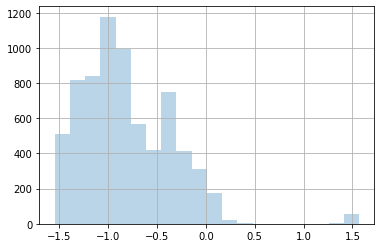

       median_userAcceleration.x  ...  max_rotationRate.z
count                   7062.000  ...            7062.000
mean                      -0.002  ...               1.322
std                        0.081  ...               1.528
min                       -1.004  ...               0.003
25%                       -0.018  ...               0.049
50%                        0.001  ...               1.005
75%                        0.020  ...               2.087
max                        0.566  ...              11.436

[8 rows x 48 columns]


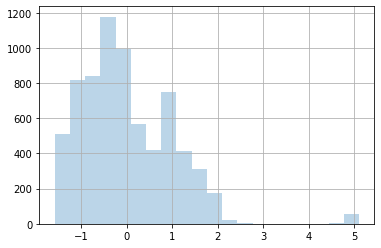

       median_userAcceleration.x  ...  max_rotationRate.z
count                   7062.000  ...            7062.000
mean                      -0.000  ...              -0.000
std                        1.000  ...               1.000
min                      -12.312  ...              -0.863
25%                       -0.188  ...              -0.833
50%                        0.044  ...              -0.208
75%                        0.275  ...               0.500
max                        6.991  ...               6.618

[8 rows x 48 columns]


In [ ]:
#Rescaling the data
#final_features = instances[['std_userAcceleration.y', 'median_attitude.pitch']]
final_features = instances.drop('label', axis=1)
final_features['max_attitude.pitch'].hist(alpha=0.3, label=label, bins=20)
plt.show()
print(final_features.describe())
featuresToScale = final_features.columns
scaler = pp.StandardScaler(copy=True)
final_features.loc[:,featuresToScale] = scaler.fit_transform(final_features[featuresToScale])

#Looking into the statistics again:
final_features['max_attitude.pitch'].hist(alpha=0.3, label=label, bins=20)
plt.show()
print(final_features.describe())

## Preparing the Model

In [ ]:
dataY = instances['label']
dataX = final_features.copy()
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.25, random_state=42, stratify=dataY) # stratified = each set contains approximately the same percentage of samples of each target class as the complete set

## PCA

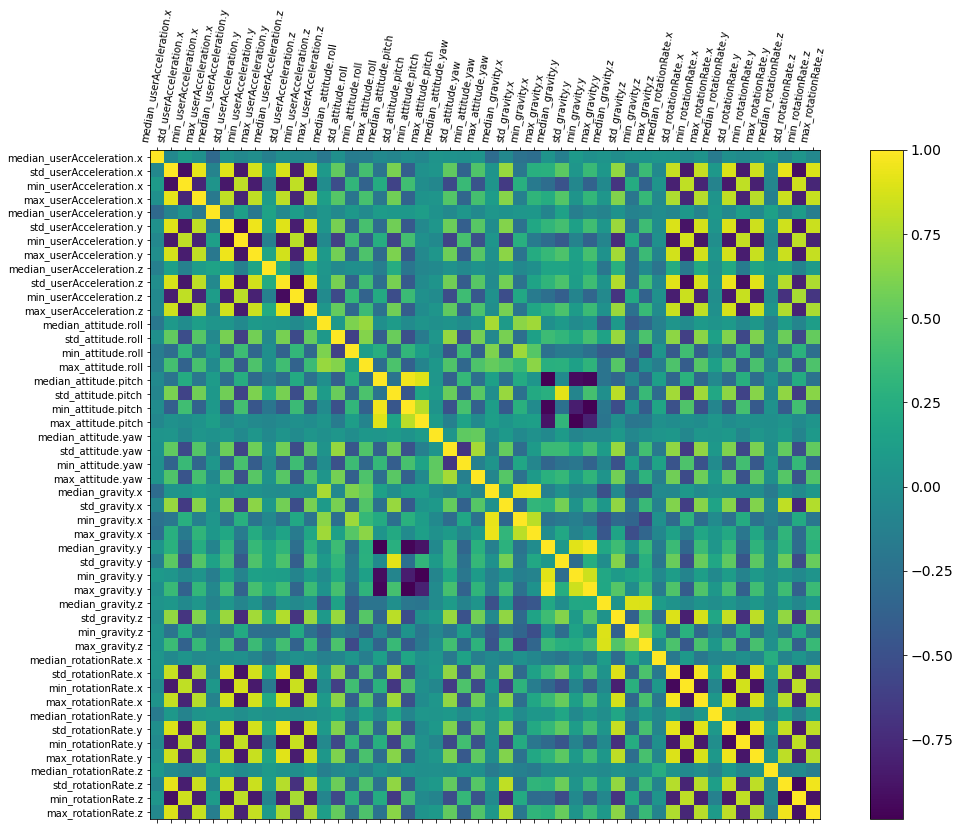

In [ ]:
correlationMatrix = pd.DataFrame(final_features).corr() 

f = plt.figure(figsize=(18, 12))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(final_features.shape[1]), final_features.columns, fontsize=10, rotation=80)
plt.yticks(range(final_features.shape[1]), final_features.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [ ]:
def scatterPlot(x_DF, y_DF, methodName):
  #Filtering the first two columns (first two dimensions):
  df = pd.DataFrame(data=x_DF.loc[:,0:1], index=x_DF.index)
  #Adding the labels:
  df = pd.concat((df,y_DF), axis=1, join="inner")
  #Labeling the columns
  df.columns = ["First Dimension", "Second Dimension", "Label"]
  sns.lmplot(x="First Dimension", y="Second Dimension", hue="Label", data=df, fit_reg=False)
  ax = plt.gca()
  ax.set_title("Visualization of the data segragation using "+methodName)

In [ ]:
def scatterPlot3D(x_DF, y_DF, methodName):
  #Filtering the first two columns (first three dimensions):
  df = pd.DataFrame(data=x_DF.loc[:,0:2], index=x_DF.index)
  #Adding the labels:
  df = pd.concat((df,y_DF), axis=1, join="inner")
  #Labeling the columns
  df.columns = ["First Dimension", "Second Dimension","Third Dimension", "Label"]

  # Plotting the figure:
  fig = px.scatter_3d(df, x='First Dimension', y='Second Dimension', z='Third Dimension',\
                      color='Label', symbol='Label', opacity=0.7, \
                      color_continuous_scale=px.colors.sequential.Viridis,
                      width = 600,
                      height = 500) 

  #https://plotly.com/python/reference/layout/#layout-transition
  title = "Visualization of the data segragation using "+methodName
  fig.update_layout(title_text=title, showlegend = True, hovermode = False)
  fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
  fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))

  fig.show() 

In [ ]:
n_components = 0.95
whiten = False
svd_solver = 'auto'
random_state = 42

# PCA Model Implementation:
model_pca = PCA(n_components=n_components, whiten=whiten, svd_solver = svd_solver, random_state=random_state)
X_train_PCA = model_pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_test_PCA = model_pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)
# Kernel PCA Model Implementation:
model_kpca = KernelPCA(n_components=48, kernel='rbf', random_state=random_state)
X_train_kPCA = model_kpca.fit_transform(X_train)
X_train_kPCA = pd.DataFrame(data=X_train_kPCA, index=X_train.index)

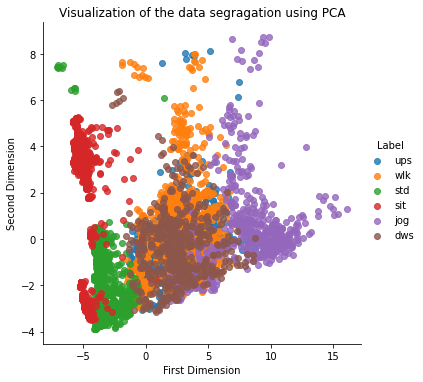

In [ ]:
scatterPlot(X_train_PCA, y_train, "PCA")

In [ ]:
scatterPlot3D(X_train_PCA, y_train, "PCA")

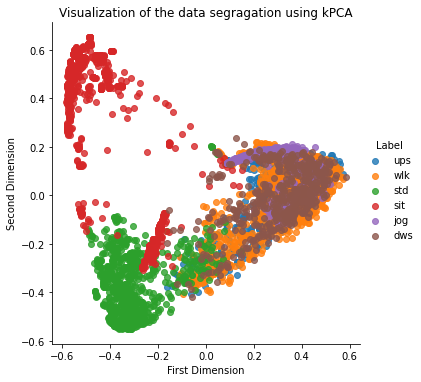

In [ ]:
scatterPlot(X_train_kPCA, y_train, "kPCA")

In [ ]:
scatterPlot3D(X_train_kPCA, y_train, "kPCA")

In [ ]:
print(model_pca.explained_variance_ratio_, '\n')
information = 0
for index, variance in enumerate(model_pca.explained_variance_ratio_):
    information = information + variance
    if information >= 0.95:
      print(f'the first {index} components carry more than 95% of the relevant Information (Variance)')
      break

[0.42817776 0.12781186 0.09368464 0.04615456 0.04067792 0.03573375
 0.03271069 0.02691823 0.02130707 0.01953771 0.01742451 0.01328353
 0.01276287 0.01165086 0.00960035 0.0095656  0.00700756] 

the first 16 components carry more than 95% of the relevant Information (Variance)


We can, again, see that going downstairs, upstairs and walking are difficult to tell apart.

#3. Testing Phase I: Baseline Models


I will always test the trained model on the test set right away. Both Precision/Recall curve and log_loss will be calculated. For the log loss we have to see what the value would be, if the model was just purely guessing. 

calculating the 'dumb log loss'

In [ ]:
all_instances = len(instances['label'])
values = dict()
values = instances['label'].value_counts()

ratio_dws = values['dws']/all_instances
ratio_ups = values['ups']/all_instances
ratio_wlk = values['wlk']/all_instances
ratio_jog = values['jog']/all_instances
ratio_std = values['std']/all_instances
ratio_sit = values['sit']/all_instances

dumb_log_loss = -1/all_instances*(math.log(ratio_dws)*values['dws'] +
                                  math.log(ratio_ups)*values['ups'] +
                                  math.log(ratio_wlk)*values['wlk'] +
                                  math.log(ratio_jog)*values['jog'] +
                                  math.log(ratio_std)*values['std'] +
                                  math.log(ratio_sit)*values['sit'])

print(dumb_log_loss)


1.7072900786284637


So everything below a log_loss of 1.7 is better than random quessing

## Logistic Regression

In [ ]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
random_state = 42
solver = 'newton-cg' # For Multi-Class, also possible: ‘sag’, ‘saga’ and ‘lbfgs’
logReg = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Model Training:
#Lists for storing scores
trainingScores = []
cvScores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, columns=['dws','ups','wlk','jog','std','sit'])
model = logReg

#kfold.split will generate indices to split data into training and test set:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train):
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
  model.fit(X_train_fold, y_train_fold)

  # We will first look log loss in the training dataset. 
  loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold))
  trainingScores.append(loglossTraining)

  # Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,:])
  cvScores.append(loglossCV)

  # printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set
loglossLogisticRegression = log_loss(y_train,predictionsBasedOnKFolds.loc[:,:])
print('-----------------------------------')
print('Log Loss on training data: ', loglossLogisticRegression)

Training Log Loss:  0.10754268189875922
CV Log Loss:  0.1576762968439838
Training Log Loss:  0.11819027587793782
CV Log Loss:  0.11604299007047146
Training Log Loss:  0.10676899285086403
CV Log Loss:  0.1795831055705659
Training Log Loss:  0.11460250652505728
CV Log Loss:  0.13693852199804074
Training Log Loss:  0.11368698058744599
CV Log Loss:  0.12847569598354047
-----------------------------------
Log Loss on training data:  0.14374595294202716


['std' 'dws' 'sit' ... 'sit' 'wlk' 'std']
              precision    recall  f1-score   support

         dws       0.88      0.84      0.86       165
         jog       0.98      0.98      0.98       168
         sit       0.99      1.00      0.99       423
         std       1.00      0.98      0.99       383
         ups       0.89      0.91      0.90       197
         wlk       0.96      0.97      0.97       430

    accuracy                           0.96      1766
   macro avg       0.95      0.95      0.95      1766
weighted avg       0.96      0.96      0.96      1766



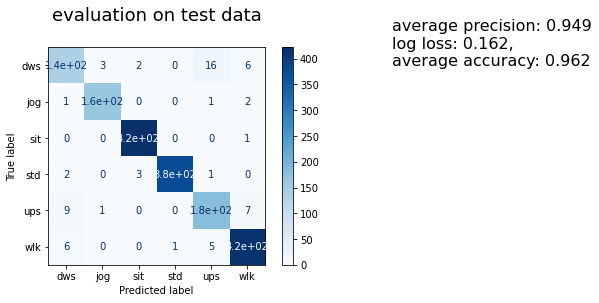

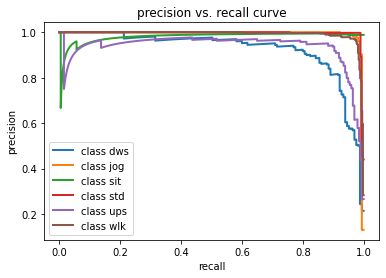

In [ ]:
y_score = model.predict_proba(X_test)
y_score_2 = model.predict(X_test)
report = classification_report(y_test, y_score_2, output_dict=True)
print(classification_report(y_test, y_score_2))
#print('Amount and Distribution of Test Data: \n', y_test.value_counts())
y_bin = pp.label_binarize(y_test, classes=model.classes_)

precision = dict()
recall = dict()
average_precision = dict()
classes = model.classes_

test_log_loss = round(log_loss(y_test, y_score), 3)
plot_confusion_matrix(model, X=X_test, y_true=y_test, labels=model.classes_, cmap='Blues')
avg_precision = round(report['macro avg']['precision'],3)
avg_accuracy = round(report['accuracy'],3)
plt.text(9, 0, f'average precision: {avg_precision}\nlog loss: {test_log_loss}\naverage accuracy: {avg_accuracy}', fontsize=16)
plt.title('evaluation on test data\n', fontsize=18)
plt.show()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
    #print('\n average precision: ', classes[i], ': ', average_precision[i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## Logistic Regression with PCA

In [ ]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
random_state = 42
solver = 'newton-cg' # For Multi-Class, also possible: ‘sag’, ‘saga’ and ‘lbfgs’
logReg = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Model Training:
#Lists for storing scores
trainingScores = []
cvScores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, columns=['dws','ups','wlk','jog','std','sit'])
model = logReg

#kfold.split will generate indices to split data into training and test set:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_PCA)), y_train):
  X_train_fold, X_cv_fold = X_train_PCA.iloc[train_index,:], X_train_PCA.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
  model.fit(X_train_fold, y_train_fold)

  # We will first look log loss in the training dataset. 
  loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold))
  trainingScores.append(loglossTraining)

  # Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,:])
  cvScores.append(loglossCV)

  # printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set
loglossLogisticRegression = log_loss(y_train,predictionsBasedOnKFolds.loc[:,:])
print('-----------------------------------')
print('Log Loss on training data with PCA: ', loglossLogisticRegression)

Training Log Loss:  0.24813132820917103
CV Log Loss:  0.30237326796950614
Training Log Loss:  0.2590765055083157
CV Log Loss:  0.2653145476367794
Training Log Loss:  0.2515225186045171
CV Log Loss:  0.315869486327103
Training Log Loss:  0.2594703049201257
CV Log Loss:  0.26432003350533745
Training Log Loss:  0.25993534812373204
CV Log Loss:  0.2569911897819927
-----------------------------------
Log Loss on training data with PCA:  0.280977745747113


              precision    recall  f1-score   support

         dws       0.86      0.69      0.77       165
         jog       0.93      0.92      0.93       168
         sit       0.98      1.00      0.99       423
         std       1.00      0.99      0.99       383
         ups       0.83      0.81      0.82       197
         wlk       0.85      0.93      0.89       430

    accuracy                           0.92      1766
   macro avg       0.91      0.89      0.90      1766
weighted avg       0.92      0.92      0.92      1766



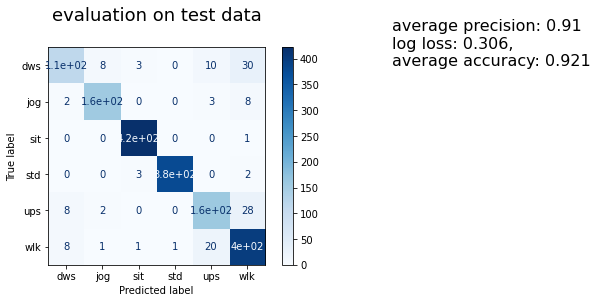

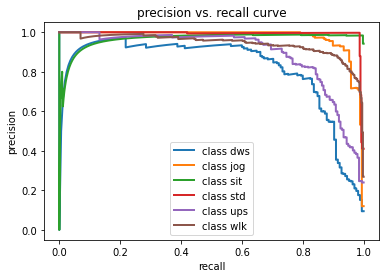

In [ ]:
y_score = model.predict_proba(X_test_PCA)
y_score_2 = model.predict(X_test_PCA)
report = classification_report(y_test, y_score_2, output_dict=True)
print(classification_report(y_test, y_score_2))
#print('Amount and Distribution of Test Data: \n', y_test.value_counts())
y_bin = pp.label_binarize(y_test, classes=model.classes_)

precision = dict()
recall = dict()
average_precision = dict()
classes = model.classes_

test_log_loss = round(log_loss(y_test, y_score), 3)
plot_confusion_matrix(model, X=X_test_PCA, y_true=y_test, labels=model.classes_, cmap='Blues')
avg_precision = round(report['macro avg']['precision'],3)
avg_accuracy = round(report['accuracy'],3)
plt.text(9, 0, f'average precision: {avg_precision}\nlog loss: {test_log_loss}\naverage accuracy: {avg_accuracy}', fontsize=16)
plt.title('evaluation on test data\n', fontsize=18)
plt.show()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
    #print('\n average precision: ', classes[i], ': ', average_precision[i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [ ]:
print('Amount of Principle Components:', X_train_PCA.shape[1])

Amount of Principle Components: 17


Using the 17 Components and transdorming the Train and Test data to those components didn't improve the results. But considering that we reduced the features more than half, it is still good i would say.

## Random Forest

In [ ]:
# Hyperparameters:
#You need to check model descriptions for the hyperparameters. 
n_estimators = 10
max_features = 'auto'
max_depth = 15
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 42
class_weight = 'balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              min_weight_fraction_leaf=min_weight_fraction_leaf,max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state,class_weight=class_weight)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Model Training:
#Lists for storing scores
trainingScores = []
cvScores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, columns=['dws','ups','wlk','jog','std','sit'])
model = RFC

#kfold.split will generate indices to split data into training and test set:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
  model.fit(X_train_fold, y_train_fold)

  # We will first look log loss in the training dataset. 
  loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold))
  trainingScores.append(loglossTraining)

  # Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,:])
  cvScores.append(loglossCV)

  # printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set
loglossRFC = log_loss(y_train,predictionsBasedOnKFolds.loc[:,:])
print('-----------------------------------')
print('RFC Log Loss on training data: ', loglossRFC)

Training Log Loss:  0.04083737278839288
CV Log Loss:  0.22049902973588625
Training Log Loss:  0.04260912278965393
CV Log Loss:  0.12121315506465614
Training Log Loss:  0.041287111371079606
CV Log Loss:  0.19384394003280528
Training Log Loss:  0.046213537249364126
CV Log Loss:  0.16731886724973838
Training Log Loss:  0.041994913621268004
CV Log Loss:  0.15237114101644156
-----------------------------------
RFC Log Loss on training data:  0.1710585638183791


              precision    recall  f1-score   support

         dws       0.90      0.85      0.88       165
         jog       0.99      0.98      0.99       168
         sit       1.00      1.00      1.00       423
         std       1.00      0.99      1.00       383
         ups       0.90      0.91      0.91       197
         wlk       0.95      0.96      0.95       430

    accuracy                           0.96      1766
   macro avg       0.96      0.95      0.95      1766
weighted avg       0.96      0.96      0.96      1766



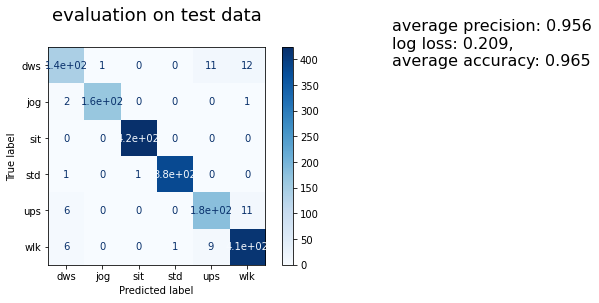

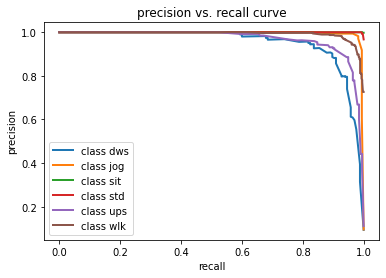

In [ ]:
y_score = model.predict_proba(X_test)
y_score_2 = model.predict(X_test)
report = classification_report(y_test, y_score_2, output_dict=True)
print(classification_report(y_test, y_score_2))
#print('Amount and Distribution of Test Data: \n', y_test.value_counts())
y_bin = pp.label_binarize(y_test, classes=model.classes_)

precision = dict()
recall = dict()
average_precision = dict()
classes = model.classes_

test_log_loss = round(log_loss(y_test, y_score), 3)
plot_confusion_matrix(model, X=X_test, y_true=y_test, labels=model.classes_, cmap='Blues')
avg_precision = round(report['macro avg']['precision'],3)
avg_accuracy = round(report['accuracy'],3)
plt.text(9, 0, f'average precision: {avg_precision}\nlog loss: {test_log_loss}\naverage accuracy: {avg_accuracy}', fontsize=16)
plt.title('evaluation on test data\n', fontsize=18)
plt.show()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
    #print('\n average precision: ', classes[i], ': ', average_precision[i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## Random Forest with PCA

In [ ]:
# Hyperparameters:
#You need to check model descriptions for the hyperparameters. 
n_estimators = 10
max_features = 'auto'
max_depth = 15
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 42
class_weight = 'balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              min_weight_fraction_leaf=min_weight_fraction_leaf,max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state,class_weight=class_weight)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Model Training:
#Lists for storing scores
trainingScores = []
cvScores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, columns=['dws','ups','wlk','jog','std','sit'])
model = RFC

#kfold.split will generate indices to split data into training and test set:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_PCA)), y_train.ravel()):
  X_train_fold, X_cv_fold = X_train_PCA.iloc[train_index,:], X_train_PCA.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
  model.fit(X_train_fold, y_train_fold)

  # We will first look log loss in the training dataset. 
  loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold))
  trainingScores.append(loglossTraining)

  # Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,:])
  cvScores.append(loglossCV)

  # printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set
loglossRFC = log_loss(y_train,predictionsBasedOnKFolds.loc[:,:])
print('-----------------------------------')
print('RFC Log Loss on training data with PCA: ', loglossRFC)

Training Log Loss:  0.06960112537113664
CV Log Loss:  0.46797124426168546
Training Log Loss:  0.06933603060945752
CV Log Loss:  0.29652008345414654
Training Log Loss:  0.07243352523352126
CV Log Loss:  0.3775166145671989
Training Log Loss:  0.07035650728189165
CV Log Loss:  0.26889290026967516
Training Log Loss:  0.0778123133359434
CV Log Loss:  0.21453261358853884
-----------------------------------
RFC Log Loss on training data with PCA:  0.3251136709399245


              precision    recall  f1-score   support

         dws       0.92      0.78      0.84       165
         jog       0.91      0.95      0.93       168
         sit       1.00      1.00      1.00       423
         std       1.00      0.99      0.99       383
         ups       0.89      0.85      0.87       197
         wlk       0.88      0.95      0.91       430

    accuracy                           0.94      1766
   macro avg       0.93      0.92      0.92      1766
weighted avg       0.94      0.94      0.94      1766



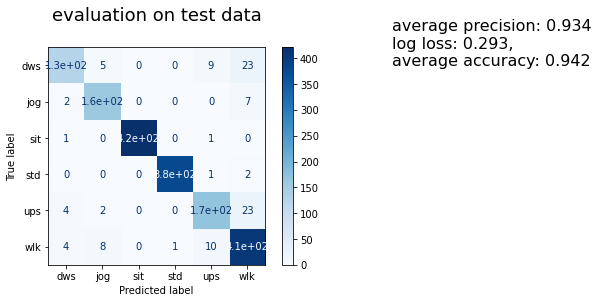

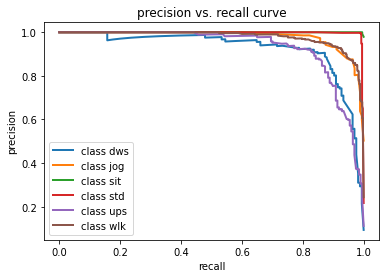

In [ ]:
y_score = model.predict_proba(X_test_PCA)
y_score_2 = model.predict(X_test_PCA)
report = classification_report(y_test, y_score_2, output_dict=True)
print(classification_report(y_test, y_score_2))
#print('Amount and Distribution of Test Data: \n', y_test.value_counts())
y_bin = pp.label_binarize(y_test, classes=model.classes_)

precision = dict()
recall = dict()
average_precision = dict()
classes = model.classes_

test_log_loss = round(log_loss(y_test, y_score), 3)
plot_confusion_matrix(model, X=X_test_PCA, y_true=y_test, labels=model.classes_, cmap='Blues')
avg_precision = round(report['macro avg']['precision'],3)
avg_accuracy = round(report['accuracy'],3)
plt.text(9, 0, f'average precision: {avg_precision}\nlog loss: {test_log_loss}\naverage accuracy: {avg_accuracy}', fontsize=16)
plt.title('evaluation on test data\n', fontsize=18)
plt.show()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
    #print('\n average precision: ', classes[i], ': ', average_precision[i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [ ]:
print('Amount of Principle Components:', X_train_PCA.shape[1])

Amount of Principle Components: 17


Here as well:

Using the 17 Components and transdorming the Train and Test data to those components didn't improve the results. But considering that we reduced the features more than half, it is still good i would say.

## Stochastic Gradient Decent

In [ ]:
# Hyperparameters:
# You need to check model descriptions for the hyperparameters. 
loss = 'log' #Since we are looking into log loss.
penalty = 'l2'
alpha = 0.0001 # Regularization constant. Higher the value, higher the regularization.
learning_rate = 'optimal'
l1_ratio = 0.15
early_stopping = False # if true, terminate training when validation score is not improving. 
validation_fraction = 0.05 # portion of the training dataset utilized if early stopping is True. 
random_state = 42

SGD = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha,l1_ratio=l1_ratio, early_stopping=early_stopping, 
                    learning_rate=learning_rate, validation_fraction= validation_fraction, random_state=random_state)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Model Training:
#Lists for storing scores
trainingScores = []
cvScores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, columns=['dws','ups','wlk','jog','std','sit'])
model = SGD

#kfold.split will generate indices to split data into training and test set:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
  model.fit(X_train_fold, y_train_fold)

  # We will first look log loss in the training dataset. 
  loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold))
  trainingScores.append(loglossTraining)

  # Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,:])
  cvScores.append(loglossCV)

  # printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set
loglossSGD = log_loss(y_train,predictionsBasedOnKFolds.loc[:,:])
print('-----------------------------------')
print('SGD Log Loss on training data: ', loglossSGD)

Training Log Loss:  0.2836583645978386
CV Log Loss:  0.4281174320863745
Training Log Loss:  0.3327872773299145
CV Log Loss:  0.3219298553759193
Training Log Loss:  0.31102365385639985
CV Log Loss:  0.4693247254554267
Training Log Loss:  0.3053116900538922
CV Log Loss:  0.3353906726286069
Training Log Loss:  0.321415935983324
CV Log Loss:  0.3669389420392874
-----------------------------------
SGD Log Loss on training data:  0.3843485915870945


              precision    recall  f1-score   support

         dws       0.78      0.88      0.83       165
         jog       0.99      0.96      0.98       168
         sit       0.99      0.99      0.99       423
         std       1.00      0.97      0.98       383
         ups       0.88      0.88      0.88       197
         wlk       0.95      0.94      0.94       430

    accuracy                           0.95      1766
   macro avg       0.93      0.94      0.93      1766
weighted avg       0.95      0.95      0.95      1766



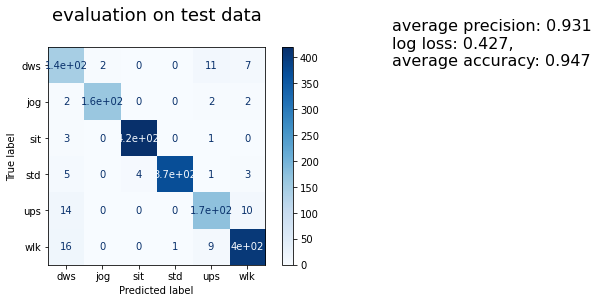

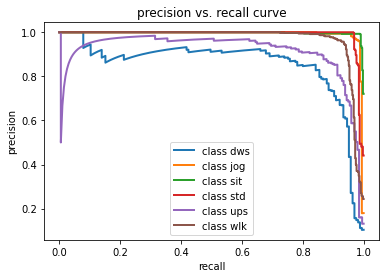

In [ ]:
y_score = model.predict_proba(X_test)
y_score_2 = model.predict(X_test)
report = classification_report(y_test, y_score_2, output_dict=True)
print(classification_report(y_test, y_score_2))
#print('Amount and Distribution of Test Data: \n', y_test.value_counts())
y_bin = pp.label_binarize(y_test, classes=model.classes_)

precision = dict()
recall = dict()
average_precision = dict()
classes = model.classes_

test_log_loss = round(log_loss(y_test, y_score), 3)
plot_confusion_matrix(model, X=X_test, y_true=y_test, labels=model.classes_, cmap='Blues')
avg_precision = round(report['macro avg']['precision'],3)
avg_accuracy = round(report['accuracy'],3)
plt.text(9, 0, f'average precision: {avg_precision}\nlog loss: {test_log_loss}\naverage accuracy: {avg_accuracy}', fontsize=16)
plt.title('evaluation on test data\n', fontsize=18)
plt.show()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
    #print('\n average precision: ', classes[i], ': ', average_precision[i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## Conclusions from Testing Phase I

The extracted Features seem to be sufficient good to get a propper result with the models. Looking at the Confusion Matrices and the Precision Recall Curves one can see that especially 3 activites seem to be difficult.
* dws
* ups
* wlk

All other activites get predicted correctly most of the time. This is quite understandable to me. Especially dws (going downstairs) and ups (going upstairs) are very similar in real life too.

Reducing the Feature Dimension from 48 to an Amount of principle components so that 95% of the Information (Variance) of the Data is preserved didn't improve the predictions. Quite the opposite happened. With 17 components holding 95% of the Variance, Logistic Regression and Random Forest got worse.
* Logistic Regression log loss     **0.14** (48 Features)
* Logistic Regression log loss PCA **0.28** (17 components)

* Random Forest log loss     **0.17** (48 Features)
* Random Forest log loss PCA **0.32** (17 components)

'dumb_log' loss was 1.7

**Random Forest** and **Logistic Regression** are doing best.

#4. Testing Phase II: Model Development


In [ ]:
dataY = instances['label']
dataX = final_features.copy()
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.25, random_state=42, stratify=dataY) # stratified = each set contains approximately the same percentage of samples of each target class as the complete set
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def build_model(hyperparams):
  if hyperparams['weight regularisation l2']!='-':
    kernel_regularizer = regularizers.l2(hyperparams['weight regularisation l2'])
  else:
    kernel_regularizer = None

  if hyperparams['initialization']!='-':
    kernel_initializer = hyperparams['initialization']
  else:
    kernel_initializer = 'glorot_uniform'

  model = models.Sequential()
  model.add(layers.Dense(hyperparams['units_hidden_layer'], kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer, activation=hyperparams['activation_hidden'], input_shape=(X_train.shape[1],)))
  if hyperparams['dropout']!='-':
      model.add(layers.Dropout(hyperparams['dropout']))
  for i in range(hyperparams['hidden_layer']-1):
    model.add(layers.Dense(hyperparams['units_hidden_layer'], kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer, activation=hyperparams['activation_hidden']))
    if hyperparams['dropout']!='-':
      model.add(layers.Dropout(hyperparams['dropout']))
  model.add(layers.Dense(6, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer, activation=hyperparams['activation_output']))
  model.compile(optimizer=hyperparams['optimizer'], loss=hyperparams['loss'], metrics=[hyperparams['metric_1'], hyperparams['metric_2']])
  #print(model.summary())
  return model

In [ ]:
def plot_learning_curves(history, parameters):
  parameter_legend = ''
  for parameter, value in parameters.items():
    parameter_legend = parameter_legend + str(parameter) + ':  ' + str(value) + '\n'
  plt.plot(history['epoch'][:],history['loss'][:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][:],history['val_loss'][:], "b-.", linewidth=1.5, label="CV test")
  plt.text(len(history['epoch'])+len(history['epoch'])/10,0, parameter_legend, fontsize=12)
  plt.legend()
  plt.ylim(0,1.5)
  #plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("categorical_crossentropy")

In [ ]:
def train_model(hyperparams, name): 
  act_dict = {0: 'dws',
              1: 'ups',
              2: 'wlk',
              3: 'jog',
              4: 'std',
              5: 'sit'}
  label_dict = {'dws': 0,
                'ups': 1,
                'wlk': 2,
                'jog': 3,
                'std': 4,
                'sit': 5}
  y_train_numbers = y_train.apply(lambda label: label_dict[label])
  y_test_numbers = y_test.apply(lambda label: label_dict[label])

  trainingScores = []
  cvScores = []
  y_train_categorical = keras.utils.to_categorical(y_train_numbers)
  y_test_categorical = keras.utils.to_categorical(y_test_numbers)

  myCheckpoint= keras.callbacks.ModelCheckpoint(f"{name}_best.h5", save_best_only=True)
  #myEarly_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

  #print('y_train Dimensions: \n', y_train_categorical.shape)
  #print(y_train_categorical)

  for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_categorical[train_index], y_train_categorical[cv_index]

    model = build_model(hyperparams)

    #Training step: verbose = 0 trains the model in silent mode 
    history = model.fit(X_train_fold, y_train_fold, epochs=hyperparams['num_epochs'], batch_size=hyperparams['batch_size'], 
                        validation_data=(X_cv_fold, y_cv_fold), callbacks=[myCheckpoint], verbose=0)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    #Evaluating the training performance:
    train_loss, train_acc, train_precision = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    trainingScores.append(train_loss)
    print('--------------------------------------------------------')
    print('Evaluation of training Data: \n', 'training loss: ', train_loss, 'training accuracy: ', train_acc)

    #Evaluating the CV pperformance:
    val_loss, val_acc, val_precision = model.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    cvScores.append(val_loss)
    print('Evaluation of validation Data: \n', 'cv loss: ', val_loss, 'cv accuracy: ', val_acc)

  training_total_loss, training_total_acc, training_total_precision = model.evaluate(X_train, y_train_categorical, verbose=0)
  #testing_loss, testing_acc = model.evaluate(X_test, y_test_categorical)
  print('--------------------------------------------------------')
  print('Loss for the training dataset: ', training_total_loss)
  print('--------------------------------------------------------')
  print('Accuracy for the training dataset: ', training_total_acc)
  print('--------------------------------------------------------')

  model.save(f'/content/drive/MyDrive/Uni/Uni Master/Master Semester 3/Data Driven Engineering I/dataset/{name}.h5')

  # graphs
  plot_learning_curves(hist, hyperparams)
  plt.title(f'accuracy on all training data: {round(training_total_acc,2)}', fontsize=18)
  plt.show()

In [ ]:
def evaluate_model_on_testdata(model):
  act_dict = {0: 'dws',
              1: 'ups',
              2: 'wlk',
              3: 'jog',
              4: 'std',
              5: 'sit'}
  label_dict = {'dws': 0,
                'ups': 1,
                'wlk': 2,
                'jog': 3,
                'std': 4,
                'sit': 5}
  y_score = model.predict(X_test)
  y_score_2 = pd.DataFrame(model.predict(X_test).argmax(axis=-1))[0].apply(lambda x: act_dict[x])
  report = classification_report(y_test, y_score_2, output_dict=True)
  print(classification_report(y_test, y_score_2))

  avg_precision = round(report['macro avg']['precision'],3)
  avg_accuracy = round(report['accuracy'],3)


  y_train_numbers = y_train.apply(lambda label: label_dict[label])
  y_test_numbers = y_test.apply(lambda label: label_dict[label])
  y_pred_numbers = model.predict(X_test).argmax(axis=-1)

  y_train_categorical = keras.utils.to_categorical(y_train_numbers)
  y_test_categorical = keras.utils.to_categorical(y_test_numbers)
  testing_loss, testing_acc, test_precision = model.evaluate(X_test, y_test_categorical)

  confusion_matrix = tf.math.confusion_matrix(labels=y_test_numbers, predictions=y_pred_numbers, num_classes=6)
  plt.matshow(confusion_matrix, cmap=plt.cm.Blues)
  figure_title = f'average precision: {round(avg_precision,3)}\nlog loss: {round(testing_loss,3)}\naverage accuracy: {round(avg_accuracy,3)}'
  plt.text(9, 0, figure_title,
         horizontalalignment='left',
         fontsize=16)
  plt.title('evaluation on test data\n\n')
  plt.xticks([0,1,2,3,4,5], [act_dict[0],act_dict[1],act_dict[2],act_dict[3],act_dict[4],act_dict[5]])
  plt.yticks([0,1,2,3,4,5], [act_dict[0],act_dict[1],act_dict[2],act_dict[3],act_dict[4],act_dict[5]])
  plt.xlabel("Predicted labels")
  plt.ylabel("True labels")
  for (i, j), z in np.ndenumerate(confusion_matrix):
    plt.text(j, i, '{}'.format(z), ha='center', va='center')
  plt.colorbar()
  plt.show()

## Base NN structure

 * Activation Functions

> - Since I got multiple output neurons (6) which are supposed to tell you the probability of the class, I will use **softmax** for the output neurons (Multinomial probability)

> - For the Hidden Layer I will start with **ReLU**

* Optimizer

> - I will start with **rmsprop**

* loss

> - I will use **categorical_crossentropy**

* Hidden Layers and Number of Neurons

> - My Dataset is relatively small, so i will start with a small structure and see what happens when I am increasing the structure

> - **2 Hidden Layers** and **32 Neurons** each

* Metric

> - I will use **accuracy** and **precission**


In [ ]:
# Hyperparameters
hyperparams = {'num_epochs':50,
               'batch_size':10,
               'hidden_layer':2,
               'units_hidden_layer': 32,
               'activation_hidden': 'relu',
               'activation_output': 'softmax',
               'loss': 'categorical_crossentropy',
               'metric_1': 'accuracy',
               'metric_2': 'Precision',
               'optimizer': 'rmsprop', # rmsprop
               'initialization': '-',
               'weight regularisation l2': '-',
               'dropout': '-',  # typically between 0.3 and 0.5 (half of weights get 0)
               'early Stopping': 'False'} 

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.0056592561304569244 training accuracy:  0.9981114268302917
Evaluation of validation Data: 
 cv loss:  0.20459997653961182 cv accuracy:  0.9726415276527405
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.002632610034197569 training accuracy:  0.9992919564247131
Evaluation of validation Data: 
 cv loss:  0.17569047212600708 cv accuracy:  0.977337121963501
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.008545630611479282 training accuracy:  0.996931791305542
Evaluation of validation Data: 
 cv loss:  0.19159935414791107 cv accuracy:  0.9782813787460327
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.006312818732112646 training accuracy:  0.9981118440628052
Evaluation of validation Data: 
 cv loss:  0.190463304519

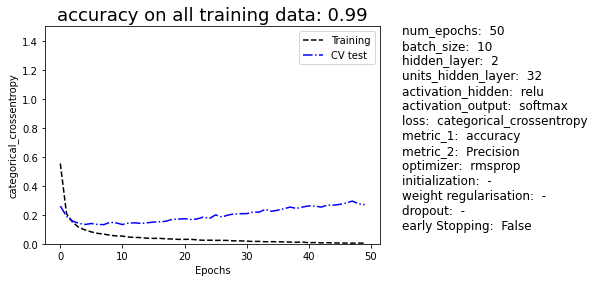

In [ ]:
train_model(hyperparams, 'firstTry')

#5. Testing Phase III: Model Regularization and Hyperparameter optimization

## Number of Neurons

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.025824138894677162 training accuracy:  0.9931539297103882
Evaluation of validation Data: 
 cv loss:  0.15470696985721588 cv accuracy:  0.9745283126831055
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.0200471431016922 training accuracy:  0.993863582611084
Evaluation of validation Data: 
 cv loss:  0.1583191305398941 cv accuracy:  0.9763928055763245
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.02439733035862446 training accuracy:  0.9931555390357971
Evaluation of validation Data: 
 cv loss:  0.12043328583240509 cv accuracy:  0.9782813787460327
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.035318274050951004 training accuracy:  0.9903233647346497
Evaluation of validation Data: 
 cv loss:  0.1684680134057998

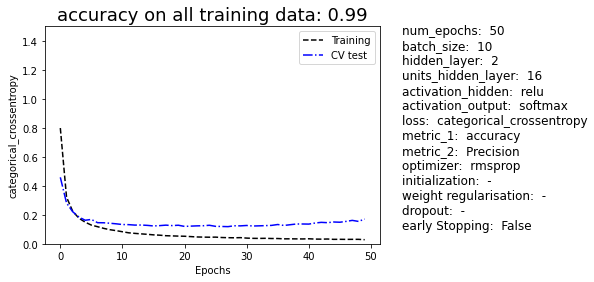

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.007568183820694685 training accuracy:  0.9981114268302917
Evaluation of validation Data: 
 cv loss:  0.13360804319381714 cv accuracy:  0.9811320900917053
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.005389525089412928 training accuracy:  0.9981118440628052
Evaluation of validation Data: 
 cv loss:  0.20723415911197662 cv accuracy:  0.9763928055763245
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.006009799428284168 training accuracy:  0.9978758692741394
Evaluation of validation Data: 
 cv loss:  0.1745583713054657 cv accuracy:  0.972615659236908
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.006666297558695078 training accuracy:  0.9985839128494263
Evaluation of validation Data: 
 cv loss:  0.1411745548248

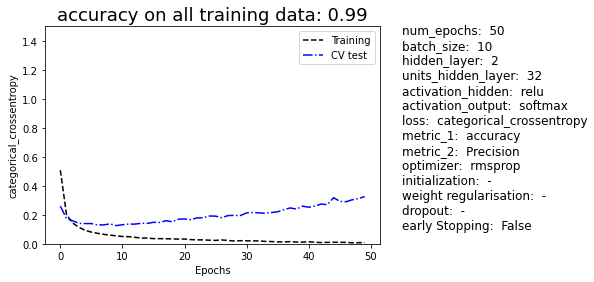

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.00262591615319252 training accuracy:  0.9988196492195129
Evaluation of validation Data: 
 cv loss:  0.24430233240127563 cv accuracy:  0.9801886677742004
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.002864015055820346 training accuracy:  0.9992919564247131
Evaluation of validation Data: 
 cv loss:  0.22784395515918732 cv accuracy:  0.9820585250854492
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.0031419515144079924 training accuracy:  0.9988199472427368
Evaluation of validation Data: 
 cv loss:  0.20518364012241364 cv accuracy:  0.9745042324066162
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.001184960245154798 training accuracy:  0.9995279908180237
Evaluation of validation Data: 
 cv loss:  0.23720839619

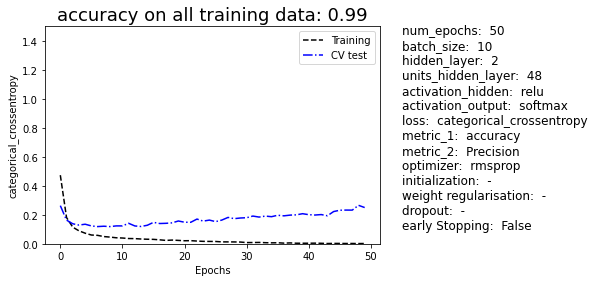

In [ ]:
hyperparams['units_hidden_layer'] = 16
train_model(hyperparams, '16Neurons')

hyperparams['units_hidden_layer'] = 32
train_model(hyperparams, '32Neurons')

hyperparams['units_hidden_layer'] = 48
train_model(hyperparams, '48Neurons')

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.07702933996915817 training accuracy:  0.9811142683029175
Evaluation of validation Data: 
 cv loss:  0.10764486342668533 cv accuracy:  0.9792453050613403
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.0659862831234932 training accuracy:  0.9804106950759888
Evaluation of validation Data: 
 cv loss:  0.14329974353313446 cv accuracy:  0.969782829284668
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.06795661151409149 training accuracy:  0.9808827042579651
Evaluation of validation Data: 
 cv loss:  0.10497187077999115 cv accuracy:  0.9678942561149597
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.0677955225110054 training accuracy:  0.9811187386512756
Evaluation of validation Data: 
 cv loss:  0.13607703149318695 

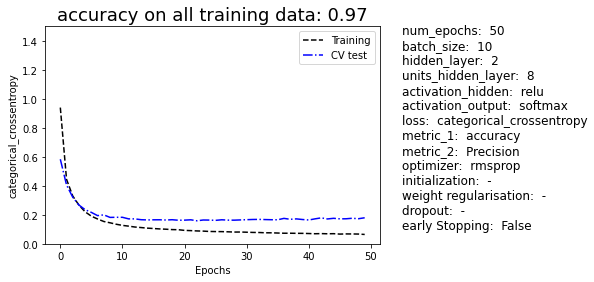

In [ ]:
hyperparams['units_hidden_layer'] = 8
train_model(hyperparams, '8Neurons')

I startet with 32. 8 Neurons per Hidden Layer seem to be better. 48 Neurons clearly overfits the model!

## Number of Hidden Layers

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.0797770768404007 training accuracy:  0.9808781743049622
Evaluation of validation Data: 
 cv loss:  0.09397962689399719 cv accuracy:  0.9811320900917053
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.07190782576799393 training accuracy:  0.9787585735321045
Evaluation of validation Data: 
 cv loss:  0.15088361501693726 cv accuracy:  0.9631727933883667
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.06607798486948013 training accuracy:  0.9827708005905151
Evaluation of validation Data: 
 cv loss:  0.12517675757408142 cv accuracy:  0.9688385128974915
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.07419305294752121 training accuracy:  0.9792305827140808
Evaluation of validation Data: 
 cv loss:  0.1127474829554557

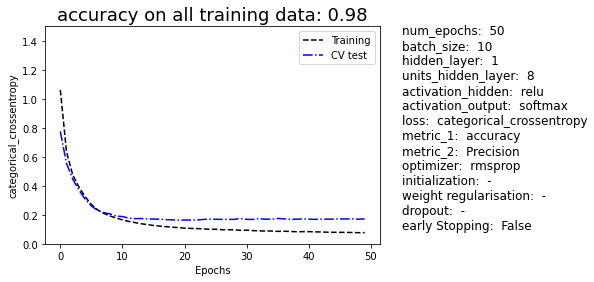

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.07042504847049713 training accuracy:  0.9825307130813599
Evaluation of validation Data: 
 cv loss:  0.09928172826766968 cv accuracy:  0.9726415276527405
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.059650570154190063 training accuracy:  0.9848949909210205
Evaluation of validation Data: 
 cv loss:  0.13741415739059448 cv accuracy:  0.9763928055763245
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.06591146439313889 training accuracy:  0.9834789037704468
Evaluation of validation Data: 
 cv loss:  0.11736097931861877 cv accuracy:  0.9660056829452515
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.06759775429964066 training accuracy:  0.9806466698646545
Evaluation of validation Data: 
 cv loss:  0.15100660920143

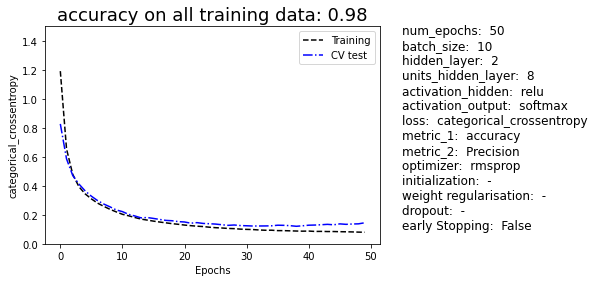

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.05825984477996826 training accuracy:  0.9841831922531128
Evaluation of validation Data: 
 cv loss:  0.12050458043813705 cv accuracy:  0.9726415276527405
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.06598761677742004 training accuracy:  0.9837148785591125
Evaluation of validation Data: 
 cv loss:  0.1551487147808075 cv accuracy:  0.9641171097755432
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.06777918338775635 training accuracy:  0.9825348258018494
Evaluation of validation Data: 
 cv loss:  0.15493421256542206 cv accuracy:  0.9669499397277832
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.06938081234693527 training accuracy:  0.9822987914085388
Evaluation of validation Data: 
 cv loss:  0.1296348869800567

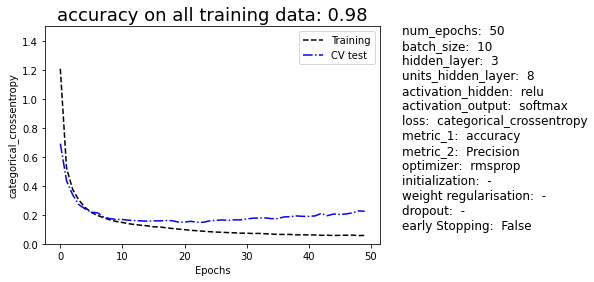

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.07867152988910675 training accuracy:  0.9796978235244751
Evaluation of validation Data: 
 cv loss:  0.14044761657714844 cv accuracy:  0.9688678979873657
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.07001903653144836 training accuracy:  0.9801746606826782
Evaluation of validation Data: 
 cv loss:  0.17648708820343018 cv accuracy:  0.9641171097755432
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.055655669420957565 training accuracy:  0.9848949909210205
Evaluation of validation Data: 
 cv loss:  0.16478154063224792 cv accuracy:  0.9660056829452515
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.06488776206970215 training accuracy:  0.9830068349838257
Evaluation of validation Data: 
 cv loss:  0.13457129895687

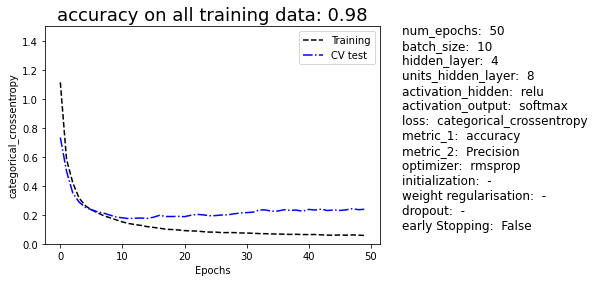

In [ ]:
hyperparams['units_hidden_layer'] = 8

hyperparams['hidden_layer'] = 1
train_model(hyperparams, '1hidden')

hyperparams['hidden_layer'] = 2
train_model(hyperparams, '2hidden')

hyperparams['hidden_layer'] = 3
train_model(hyperparams, '3hidden')

hyperparams['hidden_layer'] = 4
train_model(hyperparams, '4hidden')

As it seems, 2 Hidden Layers are good. More leads to overfitting.

## Dropout

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.17807090282440186 training accuracy:  0.9619924426078796
Evaluation of validation Data: 
 cv loss:  0.15708062052726746 cv accuracy:  0.9632075428962708
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.16394905745983124 training accuracy:  0.9660136699676514
Evaluation of validation Data: 
 cv loss:  0.263439804315567 cv accuracy:  0.9452313780784607
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.1977338194847107 training accuracy:  0.9527968168258667
Evaluation of validation Data: 
 cv loss:  0.18934088945388794 cv accuracy:  0.9442870616912842
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.17713409662246704 training accuracy:  0.959405243396759
Evaluation of validation Data: 
 cv loss:  0.23097914457321167 c

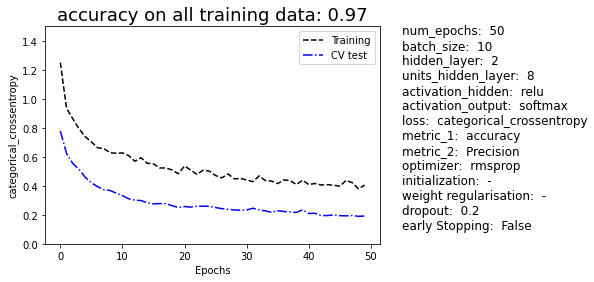

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.2545568346977234 training accuracy:  0.9497166872024536
Evaluation of validation Data: 
 cv loss:  0.2471850961446762 cv accuracy:  0.948113203048706
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.2510974705219269 training accuracy:  0.9476044178009033
Evaluation of validation Data: 
 cv loss:  0.2917073667049408 cv accuracy:  0.9367327690124512
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.25682950019836426 training accuracy:  0.9402879476547241
Evaluation of validation Data: 
 cv loss:  0.27957212924957275 cv accuracy:  0.9197356104850769
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.21190185844898224 training accuracy:  0.9523247480392456
Evaluation of validation Data: 
 cv loss:  0.21293474733829498 cv

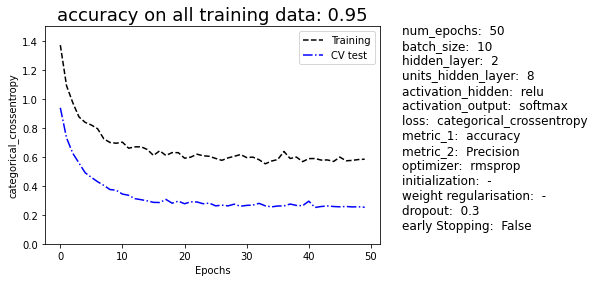

In [ ]:
hyperparams['hidden_layer'] = 2

hyperparams['dropout'] = 0.2
train_model(hyperparams, 'dropout0_2')

hyperparams['dropout'] = 0.3
train_model(hyperparams, 'dropout0_3')

I don't know why the CV Test is always better than the training ... something must be wrong but i can't figure it out :/

## Weight Regularization

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.1451607644557953 training accuracy:  0.977337121963501
Evaluation of validation Data: 
 cv loss:  0.1568288505077362 cv accuracy:  0.9783018827438354
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.12769022583961487 training accuracy:  0.981590747833252
Evaluation of validation Data: 
 cv loss:  0.1675361543893814 cv accuracy:  0.9735599756240845
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.12467391043901443 training accuracy:  0.9844229221343994
Evaluation of validation Data: 
 cv loss:  0.14577090740203857 cv accuracy:  0.9754485487937927
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.13398554921150208 training accuracy:  0.9794666171073914
Evaluation of validation Data: 
 cv loss:  0.1601279079914093 cv 

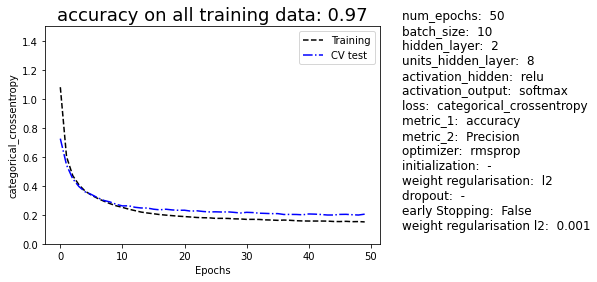

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.4374183714389801 training accuracy:  0.9537299275398254
Evaluation of validation Data: 
 cv loss:  0.4278963506221771 cv accuracy:  0.9547169804573059
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.4340362250804901 training accuracy:  0.9450082778930664
Evaluation of validation Data: 
 cv loss:  0.47343936562538147 cv accuracy:  0.9395655989646912
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.4336833357810974 training accuracy:  0.9553929567337036
Evaluation of validation Data: 
 cv loss:  0.44515255093574524 cv accuracy:  0.9480642080307007
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.4346334934234619 training accuracy:  0.9506726264953613
Evaluation of validation Data: 
 cv loss:  0.43461060523986816 cv

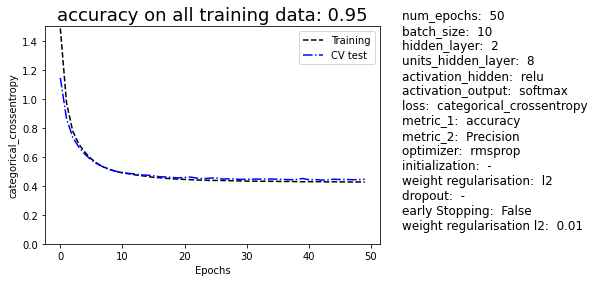

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  1.2838078737258911 training accuracy:  0.7455146312713623
Evaluation of validation Data: 
 cv loss:  1.272729754447937 cv accuracy:  0.7509434223175049
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  1.2800465822219849 training accuracy:  0.7599716782569885
Evaluation of validation Data: 
 cv loss:  1.3079112768173218 cv accuracy:  0.7384324669837952
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  1.2795016765594482 training accuracy:  0.7543072700500488
Evaluation of validation Data: 
 cv loss:  1.3010358810424805 cv accuracy:  0.7403210401535034
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  1.2919814586639404 training accuracy:  0.7358980178833008
Evaluation of validation Data: 
 cv loss:  1.250930666923523 cv accu

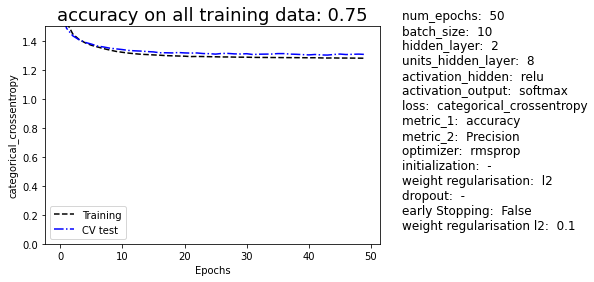

In [ ]:
hyperparams['dropout'] = '-'

hyperparams['weight regularisation l2'] = 0.001
train_model(hyperparams, 'l2_0_001')

hyperparams['weight regularisation l2'] = 0.01
train_model(hyperparams, 'l2_0_01')

hyperparams['weight regularisation l2'] = 0.1
train_model(hyperparams, 'l2_0_1')

In [ ]:
hyperparams['weight regularisation l2'] = 0.001

## Activation Function

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.14387089014053345 training accuracy:  0.9799339175224304
Evaluation of validation Data: 
 cv loss:  0.15807592868804932 cv accuracy:  0.9716981053352356
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.13437263667583466 training accuracy:  0.9773424863815308
Evaluation of validation Data: 
 cv loss:  0.18047058582305908 cv accuracy:  0.9716714024543762
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.13898076117038727 training accuracy:  0.9822987914085388
Evaluation of validation Data: 
 cv loss:  0.15922145545482635 cv accuracy:  0.9688385128974915
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.13377822935581207 training accuracy:  0.9801746606826782
Evaluation of validation Data: 
 cv loss:  0.158525153994560

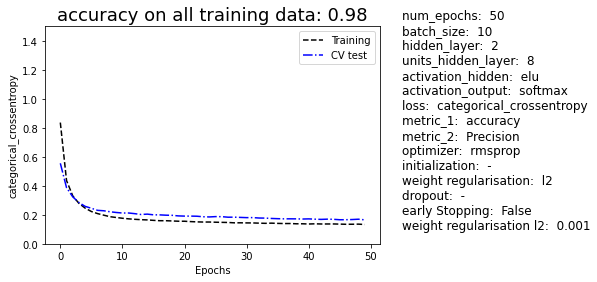

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.4719254672527313 training accuracy:  0.9553824067115784
Evaluation of validation Data: 
 cv loss:  0.46480390429496765 cv accuracy:  0.953773558139801
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.44539675116539 training accuracy:  0.9572811126708984
Evaluation of validation Data: 
 cv loss:  0.47931450605392456 cv accuracy:  0.9442870616912842
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.45423319935798645 training accuracy:  0.9596412777900696
Evaluation of validation Data: 
 cv loss:  0.4543037414550781 cv accuracy:  0.9565628170967102
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.4541788697242737 training accuracy:  0.9570450782775879
Evaluation of validation Data: 
 cv loss:  0.45876023173332214 cv a

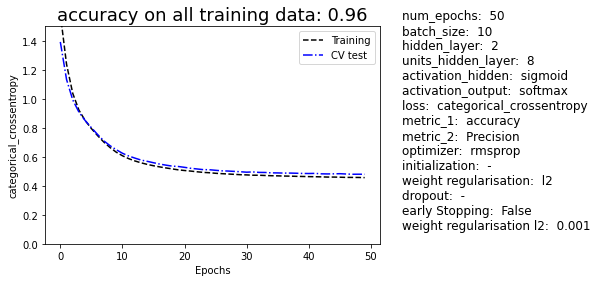

In [ ]:
hyperparams['activation_hidden'] = 'elu'
train_model(hyperparams, 'elu')

hyperparams['activation_hidden'] = 'sigmoid'
train_model(hyperparams, 'sigmoid')

In [ ]:
hyperparams['activation_hidden'] = 'elu'

Just wanted to see wether sigmoid is really worse. Yes it is. It doesn't overfit, but the accuracy is worse.

## Initialization (Vanishing Gradient)

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.12396462261676788 training accuracy:  0.9827667474746704
Evaluation of validation Data: 
 cv loss:  0.1544354408979416 cv accuracy:  0.9773585200309753
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.11671966314315796 training accuracy:  0.9832428693771362
Evaluation of validation Data: 
 cv loss:  0.16509966552257538 cv accuracy:  0.977337121963501
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.12595558166503906 training accuracy:  0.9822987914085388
Evaluation of validation Data: 
 cv loss:  0.13813020288944244 cv accuracy:  0.9735599756240845
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.12840710580348969 training accuracy:  0.9806466698646545
Evaluation of validation Data: 
 cv loss:  0.1518212854862213 

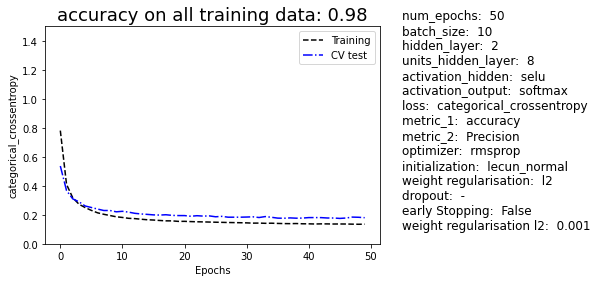

In [ ]:
hyperparams['activation_hidden'] = 'selu'
hyperparams['initialization'] = 'lecun_normal'
train_model(hyperparams, 'selu_with_LeCun')

## Optimizers

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.11025309562683105 training accuracy:  0.9889046549797058
Evaluation of validation Data: 
 cv loss:  0.13196933269500732 cv accuracy:  0.9801886677742004
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.1182742714881897 training accuracy:  0.9837148785591125
Evaluation of validation Data: 
 cv loss:  0.17110379040241241 cv accuracy:  0.977337121963501
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.10625837743282318 training accuracy:  0.9884352087974548
Evaluation of validation Data: 
 cv loss:  0.13836735486984253 cv accuracy:  0.9763928055763245
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.11331059783697128 training accuracy:  0.9860750436782837
Evaluation of validation Data: 
 cv loss:  0.14675721526145935

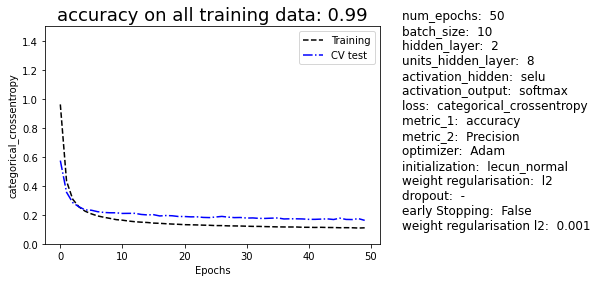

In [ ]:
hyperparams['optimizer'] = 'Adam'
train_model(hyperparams, 'Adam')

## Batch Size

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.10464119911193848 training accuracy:  0.9898489117622375
Evaluation of validation Data: 
 cv loss:  0.14082202315330505 cv accuracy:  0.9801886677742004
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.10158100724220276 training accuracy:  0.9889072179794312
Evaluation of validation Data: 
 cv loss:  0.14855273067951202 cv accuracy:  0.9820585250854492
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.1158013716340065 training accuracy:  0.9851309657096863
Evaluation of validation Data: 
 cv loss:  0.14072784781455994 cv accuracy:  0.9745042324066162
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.11918481439352036 training accuracy:  0.9825348258018494
Evaluation of validation Data: 
 cv loss:  0.1555958837270736

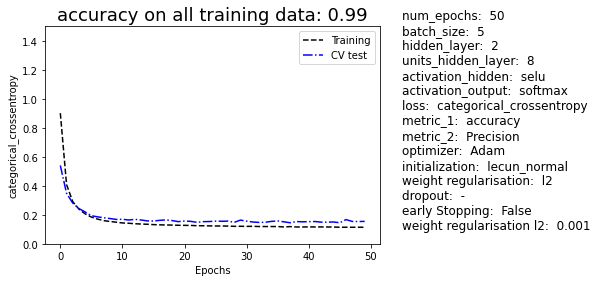

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.10564059764146805 training accuracy:  0.9886685609817505
Evaluation of validation Data: 
 cv loss:  0.13996315002441406 cv accuracy:  0.9792453050613403
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.09792403876781464 training accuracy:  0.9910314083099365
Evaluation of validation Data: 
 cv loss:  0.1458737701177597 cv accuracy:  0.977337121963501
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.10791744291782379 training accuracy:  0.9860750436782837
Evaluation of validation Data: 
 cv loss:  0.1371026188135147 cv accuracy:  0.977337121963501
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.11256233602762222 training accuracy:  0.9879631996154785
Evaluation of validation Data: 
 cv loss:  0.14379742741584778 c

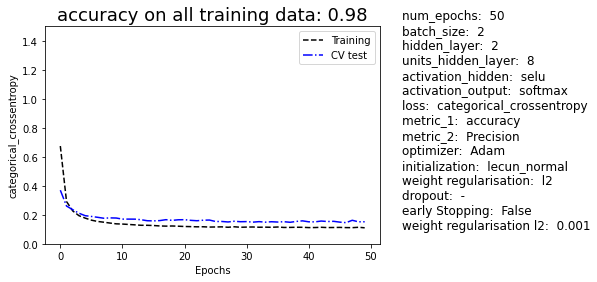

In [ ]:
hyperparams['batch_size'] = 5
train_model(hyperparams, 'batch_size_5')

hyperparams['batch_size'] = 2
train_model(hyperparams, 'batch_size_2')

Reducing the batch size helped!

## Epochs

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.10974143445491791 training accuracy:  0.9874882102012634
Evaluation of validation Data: 
 cv loss:  0.1583932489156723 cv accuracy:  0.9754716753959656
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.0971277579665184 training accuracy:  0.9903233647346497
Evaluation of validation Data: 
 cv loss:  0.14873038232326508 cv accuracy:  0.980169951915741
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.10393696278333664 training accuracy:  0.9884352087974548
Evaluation of validation Data: 
 cv loss:  0.14034028351306915 cv accuracy:  0.972615659236908
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.10000013560056686 training accuracy:  0.9889072179794312
Evaluation of validation Data: 
 cv loss:  0.13141489028930664 c

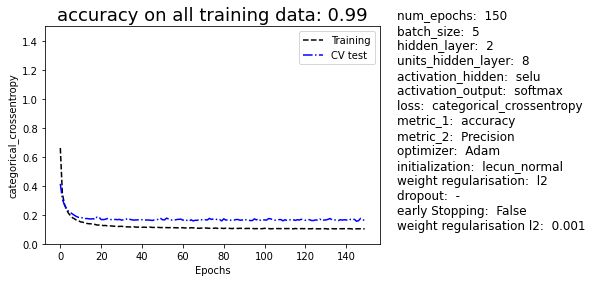

In [ ]:
hyperparams['batch_size'] = 5
hyperparams['num_epochs'] = 150
train_model(hyperparams, 'batch_size_5_epochs_150')

--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.09225229918956757 training accuracy:  0.993626058101654
Evaluation of validation Data: 
 cv loss:  0.1395082324743271 cv accuracy:  0.9820754528045654
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.09295370429754257 training accuracy:  0.9919754266738892
Evaluation of validation Data: 
 cv loss:  0.1466314196586609 cv accuracy:  0.980169951915741
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.09217363595962524 training accuracy:  0.9922114610671997
Evaluation of validation Data: 
 cv loss:  0.12407510727643967 cv accuracy:  0.977337121963501
--------------------------------------------------------
Evaluation of training Data: 
 training loss:  0.09560255706310272 training accuracy:  0.9915034174919128
Evaluation of validation Data: 
 cv loss:  0.1404416412115097 cv 

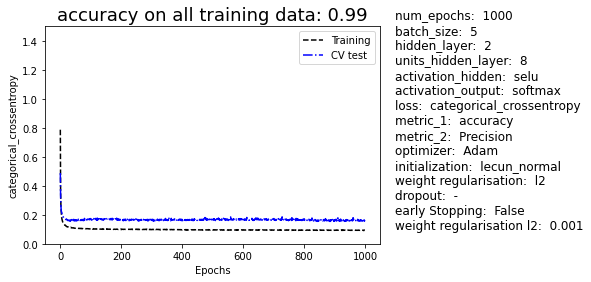

In [ ]:
hyperparams['batch_size'] = 5
hyperparams['num_epochs'] = 1000
train_model(hyperparams, 'batch_size_5_epochs_1000')

Training for a longer time doesn't really change the endresult 

## Callback

I always saved to models and saved the better one with '_best' at the end of the name. In the next section I will look on all promising models and evaluate them.

#6. Evaluation of the model predictions

---------------- **At the end of this section I compare the two best Models from Phase I and the two best Models of Phase III** ----------------

## promising models

              precision    recall  f1-score   support

         dws       0.89      0.83      0.86       165
         jog       0.98      0.95      0.96       168
         sit       1.00      1.00      1.00       423
         std       0.99      0.99      0.99       383
         ups       0.86      0.93      0.89       197
         wlk       0.96      0.96      0.96       430

    accuracy                           0.96      1766
   macro avg       0.95      0.94      0.94      1766
weighted avg       0.96      0.96      0.96      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1521 - accuracy: 0.9592 - precision: 0.9646


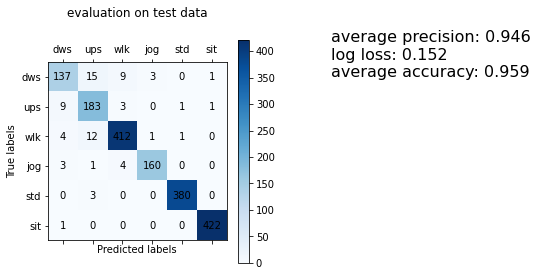

In [ ]:
loaded_model = keras.models.load_model('2hidden_best.h5')
evaluate_model_on_testdata(loaded_model)

              precision    recall  f1-score   support

         dws       0.88      0.87      0.88       165
         jog       0.97      0.96      0.97       168
         sit       1.00      1.00      1.00       423
         std       0.99      0.99      0.99       383
         ups       0.87      0.88      0.88       197
         wlk       0.96      0.96      0.96       430

    accuracy                           0.96      1766
   macro avg       0.95      0.94      0.94      1766
weighted avg       0.96      0.96      0.96      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1488 - accuracy: 0.9592 - precision: 0.9641


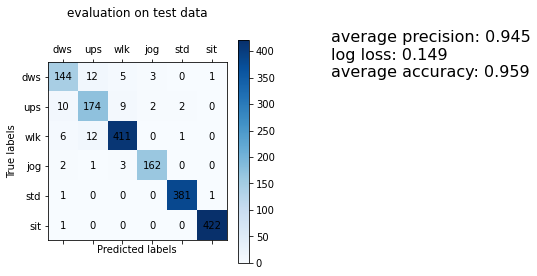

In [ ]:
loaded_model = keras.models.load_model('8Neurons_best.h5')
evaluate_model_on_testdata(loaded_model)

              precision    recall  f1-score   support

         dws       0.91      0.88      0.90       165
         jog       0.99      0.97      0.98       168
         sit       1.00      1.00      1.00       423
         std       1.00      1.00      1.00       383
         ups       0.91      0.94      0.92       197
         wlk       0.96      0.97      0.96       430

    accuracy                           0.97      1766
   macro avg       0.96      0.96      0.96      1766
weighted avg       0.97      0.97      0.97      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1428 - accuracy: 0.9706 - precision: 0.9760


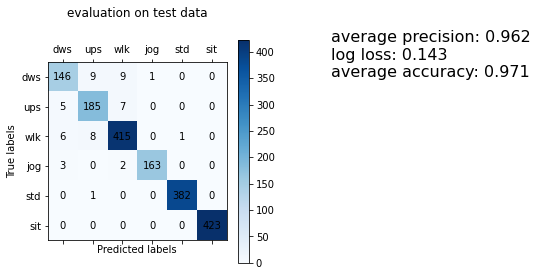

In [ ]:
loaded_model = keras.models.load_model('Adam_best.h5')
evaluate_model_on_testdata(loaded_model)

              precision    recall  f1-score   support

         dws       0.94      0.90      0.92       165
         jog       0.98      0.98      0.98       168
         sit       1.00      1.00      1.00       423
         std       0.99      1.00      1.00       383
         ups       0.89      0.93      0.91       197
         wlk       0.98      0.97      0.97       430

    accuracy                           0.97      1766
   macro avg       0.96      0.96      0.96      1766
weighted avg       0.97      0.97      0.97      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1448 - accuracy: 0.9734 - precision: 0.9783


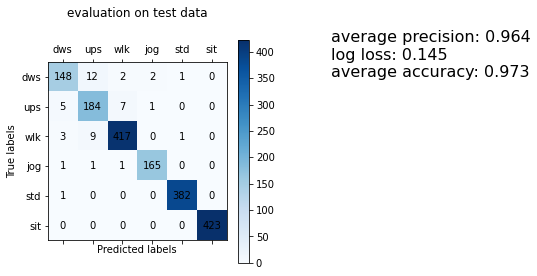

In [ ]:
loaded_model = keras.models.load_model('batch_size_5_best.h5')
evaluate_model_on_testdata(loaded_model)

              precision    recall  f1-score   support

         dws       0.94      0.90      0.92       165
         jog       0.98      0.98      0.98       168
         sit       1.00      1.00      1.00       423
         std       1.00      0.99      1.00       383
         ups       0.92      0.95      0.94       197
         wlk       0.97      0.97      0.97       430

    accuracy                           0.98      1766
   macro avg       0.97      0.97      0.97      1766
weighted avg       0.98      0.98      0.98      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1441 - accuracy: 0.9757 - precision: 0.9800


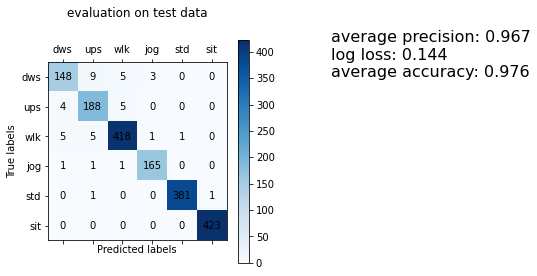

In [ ]:
loaded_model = keras.models.load_model('batch_size_2_best.h5')
evaluate_model_on_testdata(loaded_model)

              precision    recall  f1-score   support

         dws       0.93      0.85      0.89       165
         jog       0.96      0.97      0.96       168
         sit       1.00      1.00      1.00       423
         std       1.00      0.99      0.99       383
         ups       0.89      0.93      0.91       197
         wlk       0.96      0.96      0.96       430

    accuracy                           0.97      1766
   macro avg       0.95      0.95      0.95      1766
weighted avg       0.97      0.97      0.97      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1762 - accuracy: 0.9655 - precision: 0.9697


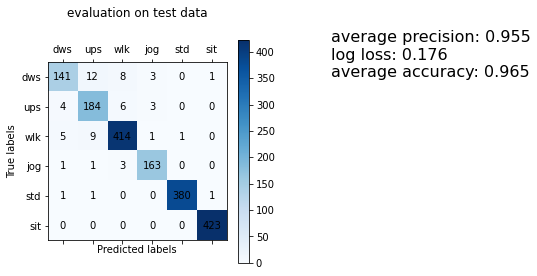

In [ ]:
loaded_model = keras.models.load_model('elu_best.h5')
evaluate_model_on_testdata(loaded_model)

              precision    recall  f1-score   support

         dws       0.93      0.88      0.91       165
         jog       0.98      0.98      0.98       168
         sit       1.00      1.00      1.00       423
         std       1.00      0.99      0.99       383
         ups       0.92      0.94      0.93       197
         wlk       0.97      0.98      0.97       430

    accuracy                           0.97      1766
   macro avg       0.96      0.96      0.96      1766
weighted avg       0.97      0.97      0.97      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1676 - accuracy: 0.9734 - precision: 0.9783


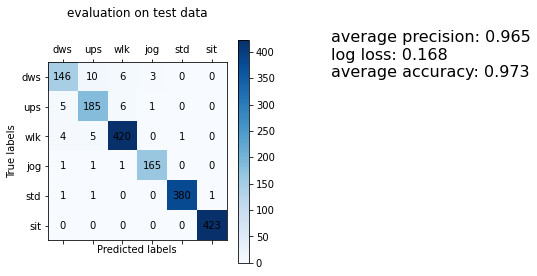

In [ ]:
loaded_model = keras.models.load_model('l2_0_001_best.h5')
evaluate_model_on_testdata(loaded_model)

              precision    recall  f1-score   support

         dws       0.94      0.88      0.91       165
         jog       0.99      0.98      0.98       168
         sit       1.00      1.00      1.00       423
         std       1.00      0.99      0.99       383
         ups       0.89      0.95      0.92       197
         wlk       0.97      0.97      0.97       430

    accuracy                           0.97      1766
   macro avg       0.96      0.96      0.96      1766
weighted avg       0.97      0.97      0.97      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1602 - accuracy: 0.9717 - precision: 0.9777


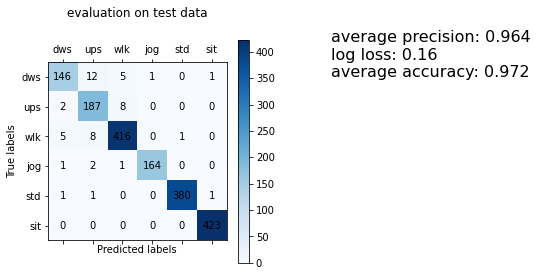

In [ ]:
loaded_model = keras.models.load_model('selu_with_LeCun_best.h5')
evaluate_model_on_testdata(loaded_model)

              precision    recall  f1-score   support

         dws       0.93      0.91      0.92       165
         jog       0.99      0.99      0.99       168
         sit       1.00      1.00      1.00       423
         std       0.99      1.00      1.00       383
         ups       0.92      0.95      0.93       197
         wlk       0.99      0.97      0.98       430

    accuracy                           0.98      1766
   macro avg       0.97      0.97      0.97      1766
weighted avg       0.98      0.98      0.98      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1417 - accuracy: 0.9779 - precision: 0.9812


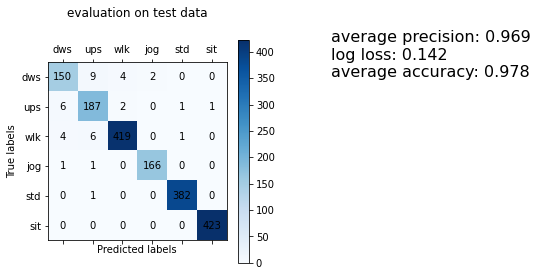

In [ ]:
loaded_model = keras.models.load_model('batch_size_5_epochs_150.h5')
evaluate_model_on_testdata(loaded_model)

              precision    recall  f1-score   support

         dws       0.94      0.89      0.92       165
         jog       0.99      0.98      0.98       168
         sit       1.00      1.00      1.00       423
         std       1.00      0.99      1.00       383
         ups       0.91      0.93      0.92       197
         wlk       0.97      0.98      0.97       430

    accuracy                           0.97      1766
   macro avg       0.97      0.96      0.96      1766
weighted avg       0.97      0.97      0.97      1766

56/56 [==============================] - 0s 1ms/step - loss: 0.1456 - accuracy: 0.9740 - precision: 0.9772


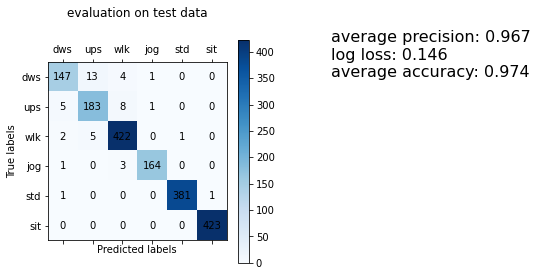

In [ ]:
loaded_model = keras.models.load_model('batch_size_5_epochs_1000_best.h5')
evaluate_model_on_testdata(loaded_model)

I could improve the Models accuracy by ~2% 
* first Model
> - average Accuracy: 0.959
> - average Precision: 0.946
> - log loss: 0.152

* last Model
> - average Accuracy: 0.974
> - average Precision: 0.967
> - log loss: 0.146

## Comparison

![picture](https://drive.google.com/uc?export=view&id=1N8roryug5Z1kVZ_2JcQ7O9yWcdN_AVFp)

#7. Lessons Learnt and Conclusions

* Neural Networks have lot of parameters you can tune with. Though it might not always be the best Solution for every Problem. In my example, the random Forest model already reached a good accuracy. The Neural Network was only slightly better at the end, but with way more effort in tuning the parameters and with way more computational effort.

* It was the first time that I used PCA. In my case, the dimension reduction didn't lead to higher accuracy. I think that's because the Dimension of my data (48 features) wasn't really high in comparison with 'normal' use case, where dimension can get higher than 3000. Nevertheless, with PCA I managed to still get good results with less than half the dimensions (17 components instead of 48 features).

* I think I could have spend more time on the feature Engineering. With a better feauture to distinguish 'ups' and 'dws' there is surely more possible in accuracy and precision. 

* Since I used readily designed features for neural network it was a machine Learning model. It would have been interesting what you can achieve with deep Learning. For example generate a picture with the time series and then use CNN (so no active feature engineering).

* I learnt a lot of new parameters you can tune your neural network with. It really isn't easy to find the 'right' combination. Now I can better understand/read/comprehend the loss curves and know a little bit more what to do in order to improve them. 

* I improved in data manipulation with pandas and also learnt how you can explore the data more efficiently (histograms, PCA, time series, etc.) 